In [ ]:
 #@markdown **Contents**: Contents. <br>
#@markdown ***
#@markdown Major Edit History: 
#@markdown - Nicholas Spevacek, 1/11/2021: Notebook created
#@markdown ***
#@markdown <br> 
#@markdown Please change `FIELDDAY_DIR` if it is located differently in your drive. This cell will error if `FIELDDAY_DIR` is incorrect.
import ipywidgets as widgets
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from io import BytesIO
from math import pi
from math import ceil
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from zipfile import ZipFile
# mount drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# Change working directory
import os
JUPYTER_DIR = '/content/drive/My Drive/Field Day/Research and Writing Projects/2022 GLS Jo Wilder Snark/Jupyter' #@param {type:"string"}
os.chdir(JUPYTER_DIR)
print(f'---\nCWD: {os.getcwd()}')

#@markdown Change pandas `max_rows` and `max_columns`
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

#@markdown *Note: There may be other variables to manually change. Look the "Set Variables" section.*

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive
---
CWD: /content/drive/My Drive/Field Day/Research and Writing Projects/2022 GLS Jo Wilder Snark/Jupyter


#Filtering

**Feature Definitions:**
- **script_type:** a number representing the script that was used for a given session (original, earnest, snark, no snark)
- **sess_time_active:** time spent actively playing in the session
- **max_level:** the max level a player reached in the session
- **sa_index:** a number representing the response to a given survey question
- **sa_text:** the actual text representation of the response (agree, somewhat agree, neutral, somewhat disagree, disagree)

**Script Types:**
- **Dry** (no humor or snark)
- **No Humor** (includes snark)
- **No Snark** (includes humor, can be described as "obedient")
- **Normal** (base script, includes snark and humor)

In [ ]:
# Get file path and create data frame
data_fpath = lambda fname: os.path.join(JUPYTER_DIR, fname)
#survey_path = 'survey_fixed.csv'
survey_path = 'Data/raw_dataset.tsv'
df = pd.read_csv(data_fpath(survey_path), sep='\t')

questions = {
    0: 'What grade are you in?',
    1: 'How well do you read in English?',
    2: 'The game grabs my attention.',
    3: 'I like watching TV shows about history.',
    4: 'Jo is friendly.',
    5: 'I think the characters are funny.',
    6: 'The characters say things that make me laugh.',
    7: 'Time flies while I\'m playing the game.',
    8: 'I like reading about history.',
    9: 'I like Jo.',
    10: 'Jo is kind.',
    11: 'The characters say funny things.',
    12: 'I forget what\'s around me while playing the game.',
    13: 'I like learning history very much.',
    14: 'I think learning history is fun.',
    15: 'I can relate to Jo.',
    16: 'The characters are entertaining.',
    17: 'I feel emotionally involved in the game.'
}

answer_map = {0.0: 4.0, 1.0: 3.0, 2.0: 2.0, 3.0: 1.0, 4.0: 0.0}

for i in range(3, len(questions), 2):
  df[f'SA{i}_sa_index'] = df[f'SA{i}_sa_index'].map(answer_map)

print(f'Sessions Before Filtering: {df.shape[0]}')

# Filter out sessions with very high or low play time
time_filter = df['sess_time_active'] > 60
df = df[time_filter]

outlier_filter = df['sess_time_active'] < 4000
df = df[outlier_filter]

# Filter out sessions that only played the first chapter
level_filter = df['max_level'] > 3
df = df[level_filter]

# Filter out sessions that continued or used a save code
save_filter = df['save_code'] == '0'
df = df[save_filter]

continue_filter = df['continue'] == 0
df = df[continue_filter]

# Filter out sessions not using the newest version of the game
version_filter = df['version'] == 10
df = df[version_filter]

# Map script type values to more descriptive labels
types = {0:'Dry', 1:'No Humor', 2:'No Snark', 3:'Normal'}
df['script_type'] = df['script_type'].map(types)

all_grades = df

# Filter out sessions where players identified themselves below the average reading level
reading_filter = df['SA1_sa_index'] != 0.0
df = df[reading_filter]

# Filter out sessions by grade
grade_filter = df['SA0_sa_index'] > 0.0 #no 3rd
df = df[grade_filter]
grade_filter = df['SA0_sa_index'] < 4.0 #no other
df = df[grade_filter]

# TODO(@nspevacek): Filter out sessions that always selected leftmost or rightmost answers
#survey_filter = (df['SA0_sa_index'] == 0.0) & (df['SA1_sa_index'] == 0.0)
#df = df[survey_filter]

print(f'Sessions After Filtering: {df.shape[0]}')

# Group data for comparing across script types
groups = df.groupby('script_type')

dry = groups.get_group('Dry')
no_humor = groups.get_group('No Humor')
no_snark = groups.get_group('No Snark')
normal = groups.get_group('Normal')

# Filter only sessions that completed game
completed_filter = df['max_level'] == 23
completed = df[completed_filter]

c_groups = completed.groupby('script_type')

Sessions Before Filtering: 27775
Sessions After Filtering: 4918


In [ ]:
print(f'Dry Script Sessions: {dry.shape[0]}')
print(f'No Humor Script Sessions: {no_humor.shape[0]}')
print(f'No Snark Script Sessions: {no_snark.shape[0]}')
print(f'Normal Script Sessions: {normal.shape[0]}')

Dry Script Sessions: 1256
No Humor Script Sessions: 1226
No Snark Script Sessions: 1244
Normal Script Sessions: 1192


# Progression and Active Time Viz

count    4918.000000
mean     1159.708388
std       726.718719
min        75.608000
25%       535.117250
50%      1043.953500
75%      1654.367250
max      3949.748000
Name: sess_time_active, dtype: float64

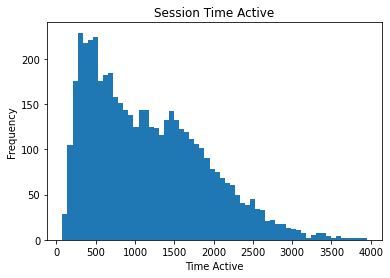

In [ ]:
df['sess_time_active'].plot(kind='hist', bins=60)
plt.title('Session Time Active')
plt.xlabel('Time Active')
df['sess_time_active'].describe()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Active Play Time')

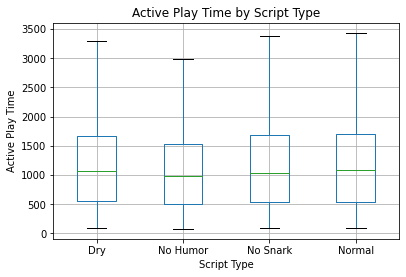

In [ ]:
df.boxplot(column='sess_time_active', by='script_type', showfliers=False)
plt.suptitle('')
plt.title('Active Play Time by Script Type')
plt.xlabel('Script Type')
plt.ylabel('Active Play Time')

count    4918.000000
mean       13.527450
std         6.994867
min         4.000000
25%         7.000000
50%        12.000000
75%        22.000000
max        23.000000
Name: max_level, dtype: float64

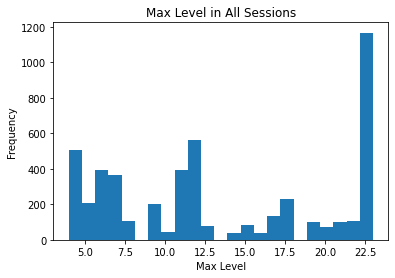

In [ ]:
df['max_level'].plot(kind='hist', bins=23)
plt.title('Max Level in All Sessions')
plt.xlabel('Max Level')
df['max_level'].describe()

In [ ]:
display(df['max_level'].value_counts().rename_axis('Max Level Reached').to_frame('Counts'))

,Counts
Max Level Reached,
23,1167
12,565
4,504
11,396
6,392
7,363
18,229
5,206
9,201


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Max Level')

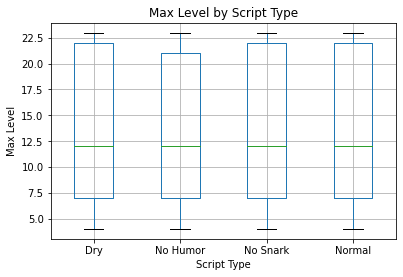

In [ ]:
df.boxplot(column='max_level', by='script_type')
plt.suptitle('')
plt.title('Max Level by Script Type')
plt.xlabel('Script Type')
plt.ylabel('Max Level')

Text(0, 0.5, 'Active Play Time')

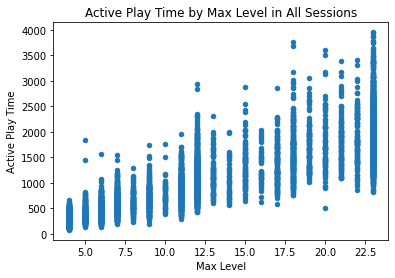

In [ ]:
df.plot(kind='scatter', x='max_level', y='sess_time_active')
plt.title('Active Play Time by Max Level in All Sessions')
plt.xlabel('Max Level')
plt.ylabel('Active Play Time')

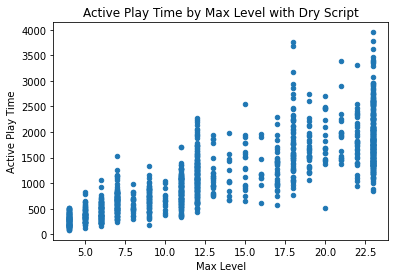

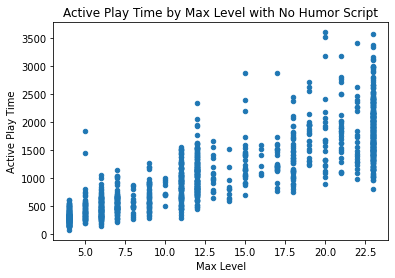

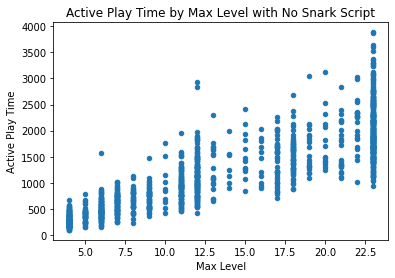

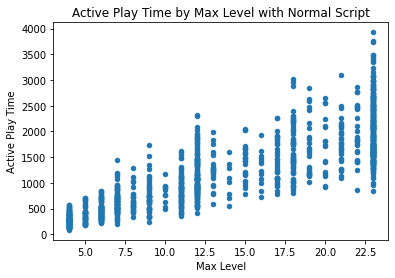

In [ ]:
for index, script in enumerate([dry, no_humor, no_snark, normal]):
  script.plot(kind='scatter', x='max_level', y='sess_time_active')
  plt.title(f'Active Play Time by Max Level with {types[index]} Script')
  plt.xlabel('Max Level')
  plt.ylabel('Active Play Time')

In [ ]:
def pct_completion(data):
  max_levels = data['max_level'].value_counts()
  completed_sessions = max_levels.get(23)
  return (completed_sessions / sum(max_levels.values)) * 100

print(f'Total Percent Completion: {pct_completion(df):.2f}%')

Total Percent Completion: 23.73%


In [ ]:
print(f'Dry: {pct_completion(dry):.2f}%')
print(f'No Humor: {pct_completion(no_humor):.2f}%')
print(f'No Snark: {pct_completion(no_snark):.2f}%')
print(f'Normal: {pct_completion(normal):.2f}%')

Dry: 23.65%
No Humor: 23.00%
No Snark: 24.76%
Normal: 23.49%


Text(0.5, 0, 'Time Active')

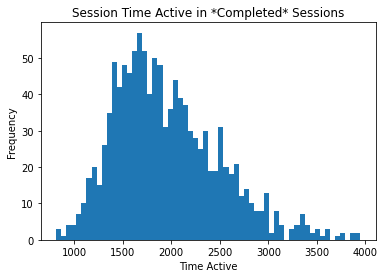

In [ ]:
completed['sess_time_active'].plot(kind='hist', bins=60)
plt.title('Session Time Active in *Completed* Sessions')
plt.xlabel('Time Active')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Active Play Time')

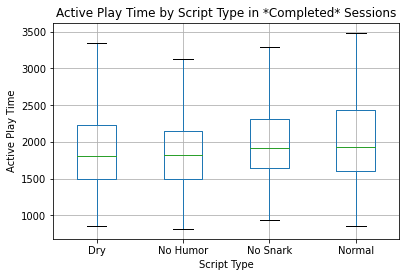

In [ ]:
completed.boxplot(column='sess_time_active', by='script_type', showfliers=False)
plt.suptitle('')
plt.title('Active Play Time by Script Type in *Completed* Sessions')
plt.xlabel('Script Type')
plt.ylabel('Active Play Time')

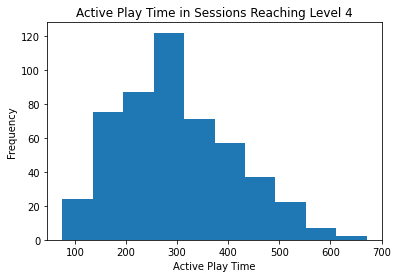

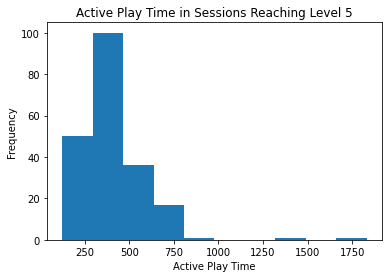

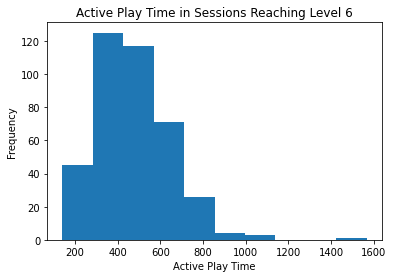

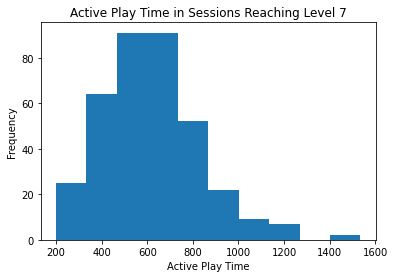

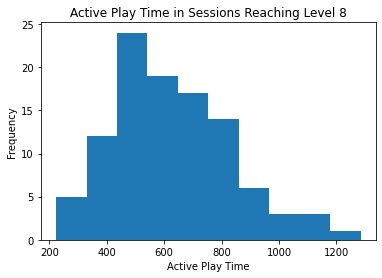

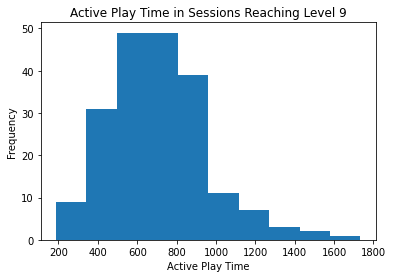

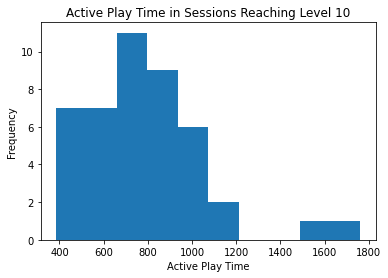

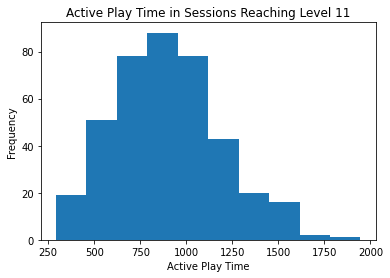

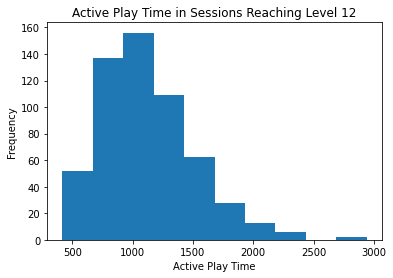

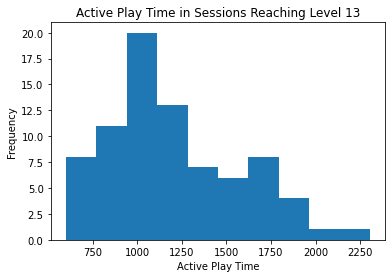

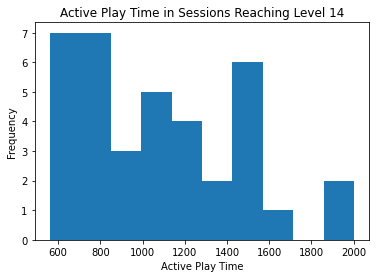

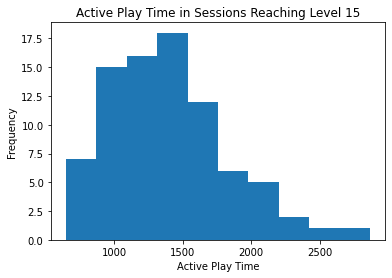

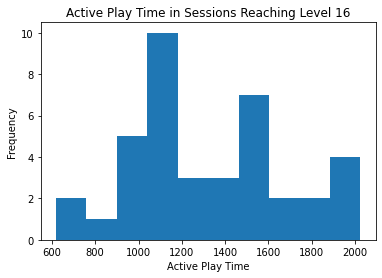

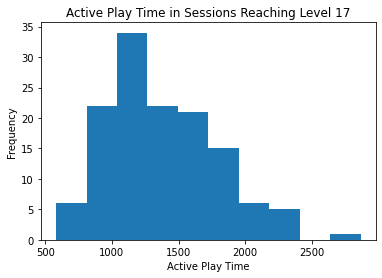

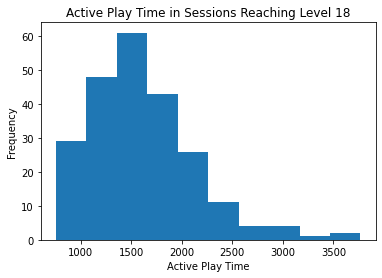

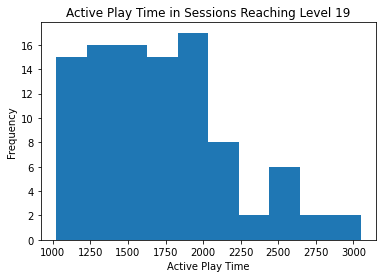

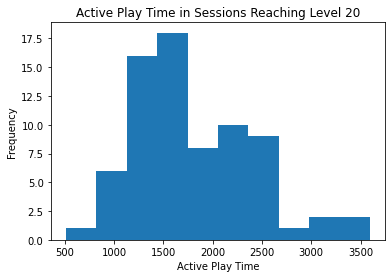

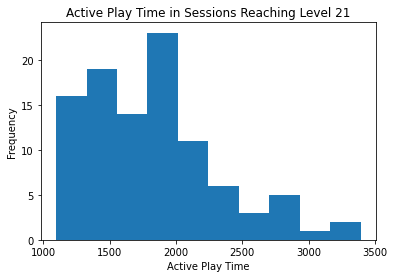

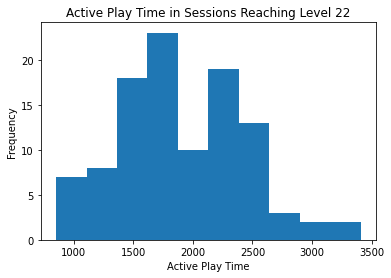

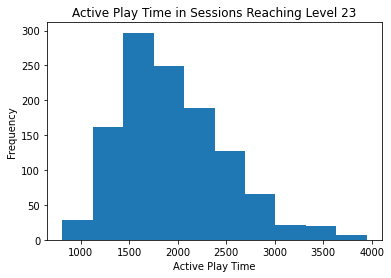

In [ ]:
# TODO(@nspevacek): time per level achieved (speed)
for level in range(4, 24):
  filter = df['max_level'] == level
  current = df[filter]
  current['sess_time_active'].plot(kind='hist')
  plt.title(f'Active Play Time in Sessions Reaching Level {level}')
  plt.xlabel('Active Play Time')
  plt.show()

# Questions Viz

Survey Questions:


1.   What grade are you in?
2.   How well do you read in English?
3.   The game grabs my attention.
4.   I like watching TV shows about history.
5.   Jo is friendly.
6.   I think the characters are funny.
7.   The characters say things that make me laugh.
8.   Time flies while I'm playing the game.
9.   I like reading about history.
10.  I like Jo.
11.  Jo is kind.
12.  The characters say funny things.
13.  I forget what's around me while playing the game.
14.  I like learning history very much.
15.  I think learning history is fun.
16.  I can relate to Jo.
17.  The characters are entertaining.
18.  I feel emotionally involved in the game.

In [ ]:
# Compute percent values for each response and arrange in a new dataframe for visualizing
def find_averages(input_df):
  columns = []

  for i in range (0, len(questions)):
    columns.append(f'SA{i}_sa_index')

  script_labels = ['Dry', 'No Humor', 'No Snark', 'Normal']
  counts = {}
  averages = {}

  df_percents = pd.DataFrame({})

  for script in script_labels:
    for index, response in enumerate(columns):
      counts[response] = input_df[response].value_counts()

  for index, response in enumerate(columns):
    num_responses = len(counts[response]['Normal'].keys())

    for j in range(0, 5):
      df_percents[f'Q{index+1} R{j} Percent'] = [] 

  for script in script_labels:
    averages = []

    for index, response in enumerate(columns):
      total_answers = counts[response][script].sum()

      for n in [0.0, 1.0, 2.0, 3.0, 4.0]:
        if n in counts[response][script].keys():
          averages.append(counts[response][script][n] / total_answers)
        else:
          averages.append(0.0)

    df_percents.loc[script] = averages

  return df_percents

survey_avgs = find_averages(groups)
display(survey_avgs)

,Q1 R0 Percent,Q1 R1 Percent,Q1 R2 Percent,Q1 R3 Percent,Q1 R4 Percent,Q2 R0 Percent,Q2 R1 Percent,Q2 R2 Percent,Q2 R3 Percent,Q2 R4 Percent,Q3 R0 Percent,Q3 R1 Percent,Q3 R2 Percent,Q3 R3 Percent,Q3 R4 Percent,Q4 R0 Percent,Q4 R1 Percent,Q4 R2 Percent,Q4 R3 Percent,Q4 R4 Percent,Q5 R0 Percent,Q5 R1 Percent,Q5 R2 Percent,Q5 R3 Percent,Q5 R4 Percent,Q6 R0 Percent,Q6 R1 Percent,Q6 R2 Percent,Q6 R3 Percent,Q6 R4 Percent,Q7 R0 Percent,Q7 R1 Percent,Q7 R2 Percent,Q7 R3 Percent,Q7 R4 Percent,Q8 R0 Percent,Q8 R1 Percent,Q8 R2 Percent,Q8 R3 Percent,Q8 R4 Percent,Q9 R0 Percent,Q9 R1 Percent,Q9 R2 Percent,Q9 R3 Percent,Q9 R4 Percent,Q10 R0 Percent,Q10 R1 Percent,Q10 R2 Percent,Q10 R3 Percent,Q10 R4 Percent,Q11 R0 Percent,Q11 R1 Percent,Q11 R2 Percent,Q11 R3 Percent,Q11 R4 Percent,Q12 R0 Percent,Q12 R1 Percent,Q12 R2 Percent,Q12 R3 Percent,Q12 R4 Percent,Q13 R0 Percent,Q13 R1 Percent,Q13 R2 Percent,Q13 R3 Percent,Q13 R4 Percent,Q14 R0 Percent,Q14 R1 Percent,Q14 R2 Percent,Q14 R3 Percent,Q14 R4 Percent,Q15 R0 Percent,Q15 R1 Percent,Q15 R2 Percent,Q15 R3 Percent,Q15 R4 Percent,Q16 R0 Percent,Q16 R1 Percent,Q16 R2 Percent,Q16 R3 Percent,Q16 R4 Percent,Q17 R0 Percent,Q17 R1 Percent,Q17 R2 Percent,Q17 R3 Percent,Q17 R4 Percent,Q18 R0 Percent,Q18 R1 Percent,Q18 R2 Percent,Q18 R3 Percent,Q18 R4 Percent
Dry,0.0,0.371815,0.329618,0.298567,0.0,0.0,0.349633,0.650367,0.0,0.0,0.029970,0.043956,0.130869,0.182817,0.612388,0.164779,0.116375,0.304840,0.159629,0.254377,0.022774,0.028986,0.159420,0.180124,0.608696,0.190178,0.118077,0.338558,0.148380,0.204807,0.349345,0.093886,0.288210,0.102620,0.165939,0.088889,0.064444,0.213333,0.162222,0.471111,0.116071,0.084821,0.281250,0.147321,0.370536,0.040268,0.026846,0.208054,0.158837,0.565996,0.047493,0.034301,0.171504,0.184697,0.562005,0.272727,0.117647,0.328877,0.114973,0.165775,0.212938,0.061995,0.261456,0.161725,0.301887,0.140541,0.062162,0.264865,0.170270,0.362162,0.084388,0.046414,0.210970,0.151899,0.506329,0.142857,0.060606,0.341991,0.199134,0.255411,0.095652,0.008696,0.221739,0.191304,0.482609,0.166667,0.078947,0.276316,0.135965,0.342105
No Humor,0.0,0.358891,0.343393,0.297716,0.0,0.0,0.329698,0.670302,0.0,0.0,0.030720,0.027542,0.148305,0.174788,0.618644,0.178844,0.111232,0.315158,0.172301,0.222465,0.038504,0.075908,0.254125,0.253025,0.378438,0.175556,0.132222,0.291111,0.170000,0.231111,0.295045,0.146396,0.261261,0.139640,0.157658,0.071101,0.052752,0.250000,0.178899,0.447248,0.111369,0.076566,0.299304,0.164733,0.348028,0.049065,0.042056,0.254673,0.158879,0.495327,0.060773,0.074586,0.309392,0.229282,0.325967,0.273239,0.092958,0.329577,0.112676,0.191549,0.172805,0.099150,0.271955,0.155807,0.300283,0.106017,0.091691,0.323782,0.163324,0.315186,0.068376,0.034188,0.260684,0.162393,0.474359,0.112554,0.103896,0.337662,0.155844,0.290043,0.061135,0.039301,0.279476,0.165939,0.454148,0.167401,0.066079,0.286344,0.123348,0.356828
No Snark,0.0,0.356913,0.358521,0.284566,0.0,0.0,0.330858,0.669142,0.0,0.0,0.020942,0.020942,0.118325,0.145550,0.694241,0.174620,0.113883,0.286334,0.180043,0.245119,0.019672,0.019672,0.133333,0.181421,0.645902,0.160793,0.109031,0.266520,0.188326,0.275330,0.286364,0.100000,0.263636,0.145455,0.204545,0.075862,0.034483,0.206897,0.213793,0.468966,0.100939,0.084507,0.269953,0.176056,0.368545,0.028169,0.018779,0.185446,0.131455,0.636150,0.026110,0.028721,0.154047,0.148825,0.642298,0.233062,0.105691,0.243902,0.162602,0.254743,0.212534,0.092643,0.223433,0.133515,0.337875,0.136612,0.062842,0.245902,0.150273,0.404372,0.082645,0.024793,0.235537,0.161157,0.495868,0.116183,0.078838,0.331950,0.195021,0.278008,0.066390,0.041494,0.211618,0.182573,0.497925,0.196653,0.087866,0.238494,0.142259,0.334728
Normal,0.0,0.344799,0.360738,0.294463,0.0,0.0,0.311207,0.688793,0.0,0.0,0.034896,0.032715,0.115594,0.190840,0.625954,0.168729,0.121485,0.298088,0.194601,0.217098,0.035147,0.058957,0.230159,0.255102,0.420635,0.147260,0.121005,0.287671,0.200913,0.243151,0.291391,0.108168,0.258278,0.156733,0.185430,0.099099,0.045045,0.

In [ ]:
colors = [
          '#4287f5',
          '#42f5da',
          '#42f54b',
          '#b6f542',
          '#f5e342'
]

def response_pct_plot(df, fields, num):
  fig, ax = plt.subplots(1, figsize=(8, 6))
  x = np.arange(0, len(df.index))

  if num == 0:
    labels = ['3rd', '4th', '5th', '6th', 'Other']
  elif num == 1:
    labels = ['Not a very good reader', 'An OK reader', 'Very good reader']
  else:
    labels = ['Disagree', 'Somewhat Disagree', 'Neutral', 'Somewhat Agree', 'Agree']

    #if num % 2 == 1:
    #  fields = fields[::-1]

  left = len(df) * [0]
  for i, name in enumerate(fields):
    plt.barh(df.index, df[name], left=left, color=colors[i])
    left = left + df[name]

  plt.title(f"Question {num+1}: {questions[num]}", loc='left')
  plt.legend(labels, bbox_to_anchor=([1, 1, 0, 0]), ncol=1, frameon=False)

  xticks = np.arange(0, 1.1, 0.1)
  xlabels = ['{}%'.format(i) for i in np.arange(0, 101, 10)]
  plt.xticks(xticks, xlabels)

  plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
  ax.set_axisbelow(True)
  ax.xaxis.grid(color='gray', linestyle='dashed')

  plt.show()

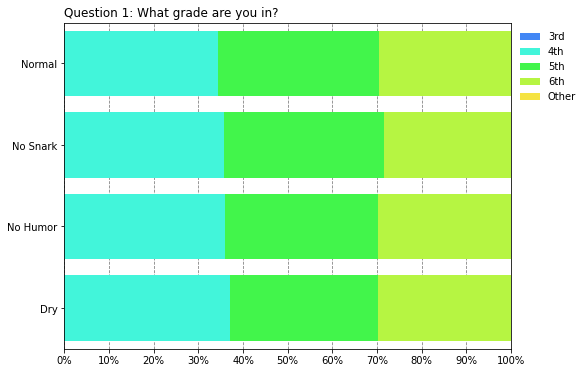

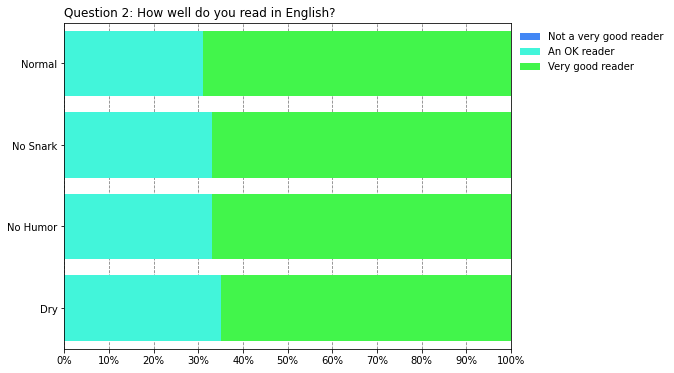

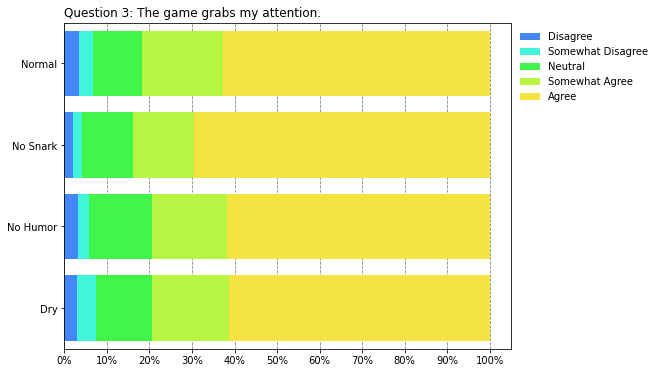

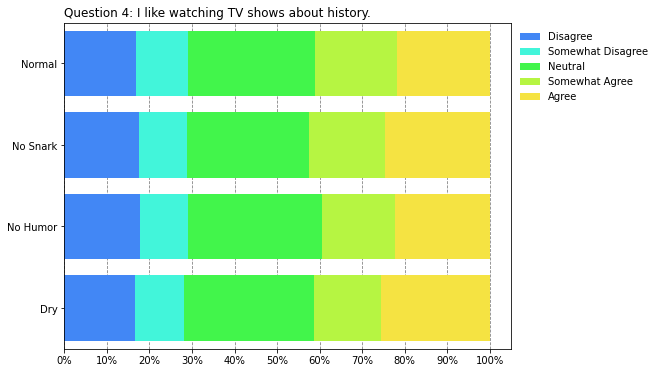

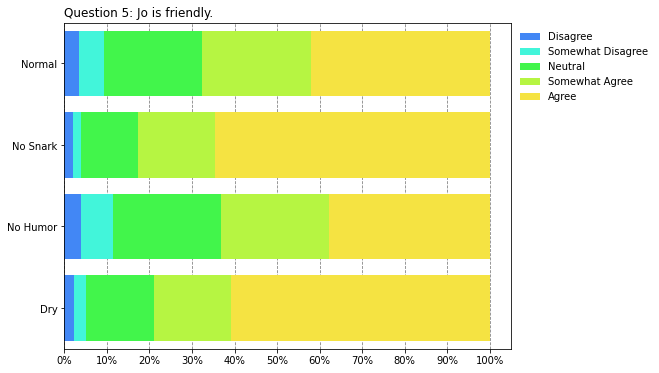

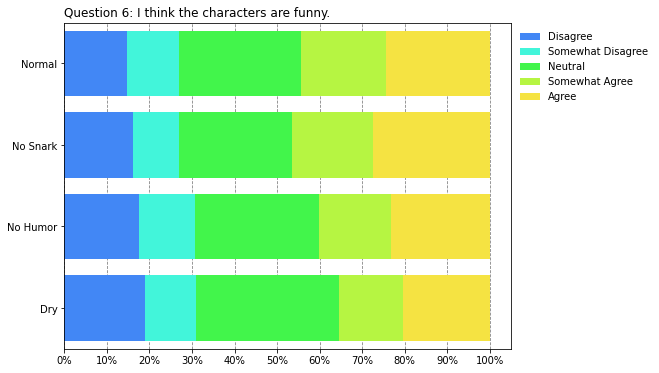

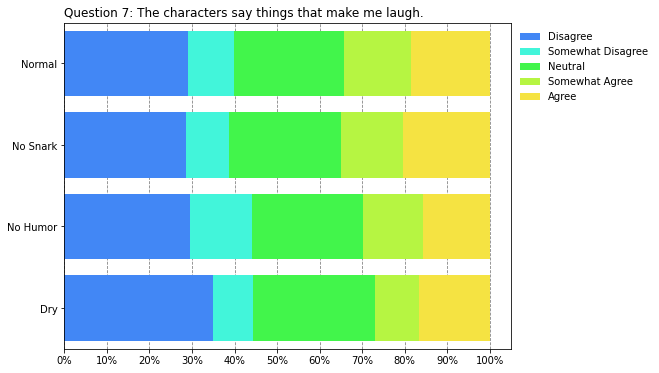

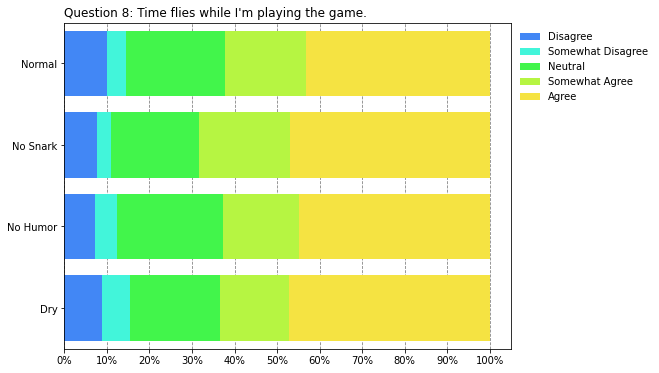

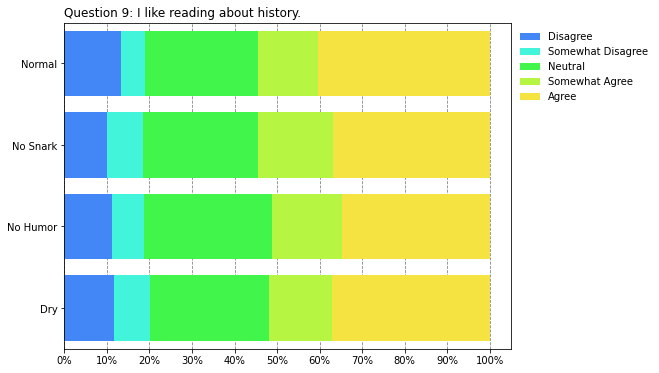

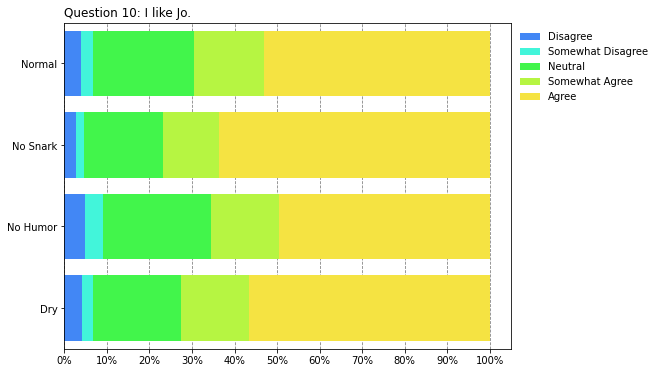

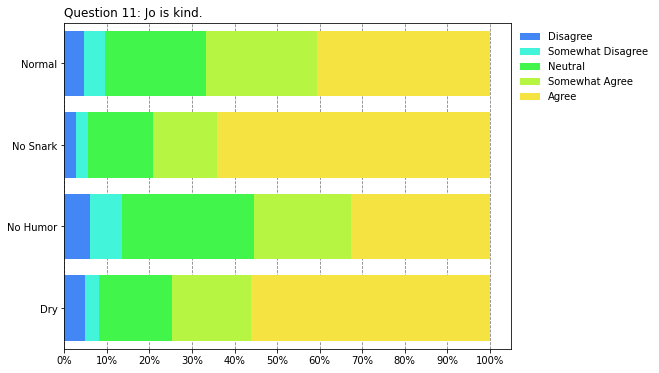

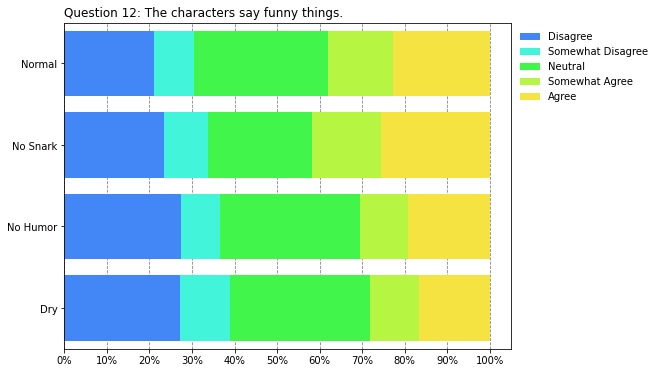

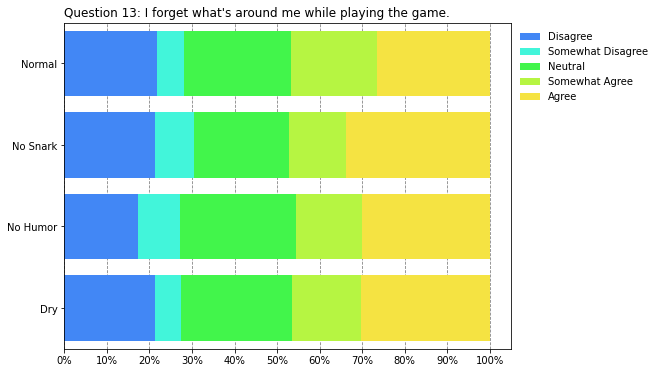

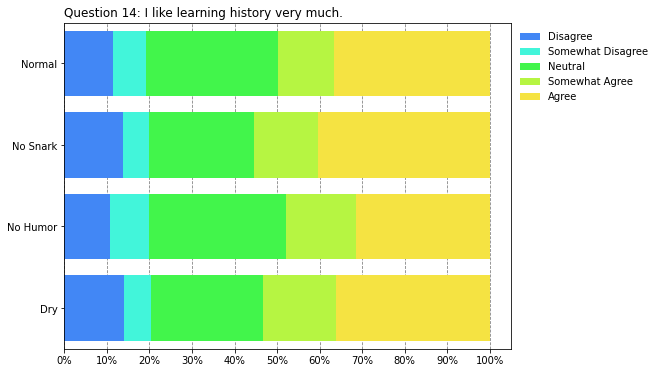

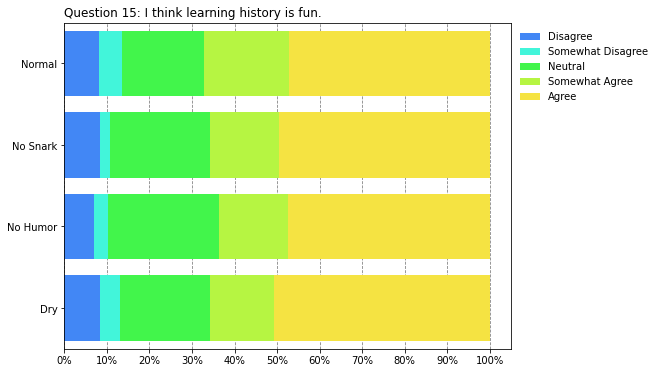

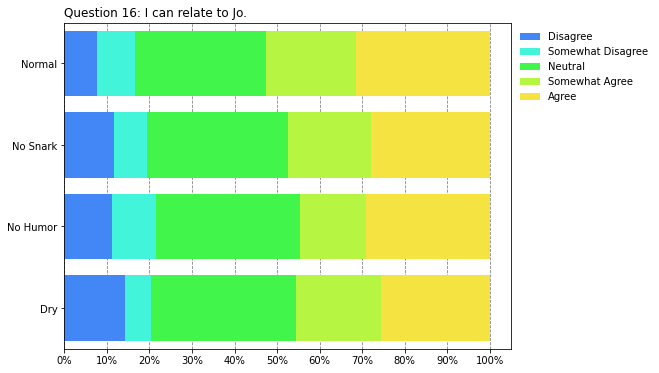

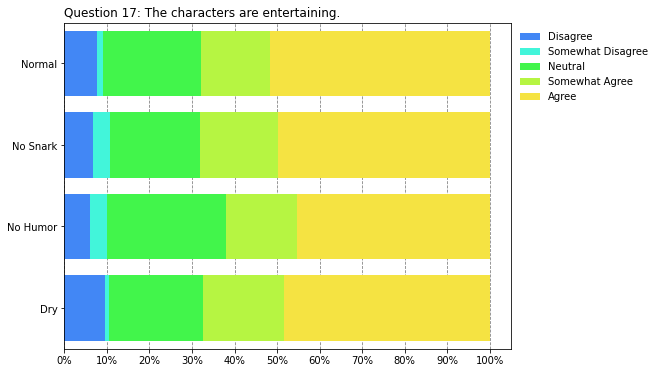

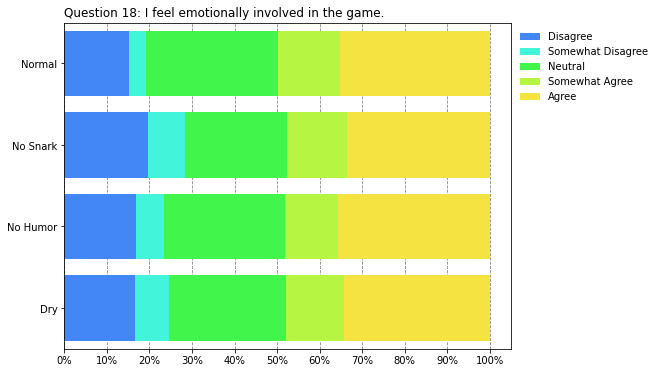

In [ ]:
headers = survey_avgs.columns.tolist()
num = 0

for i in range(0, len(headers), 5):
  response_pct_plot(survey_avgs, headers[i:i+5], num)
  num += 1


**Initial observations**


- Question 5: More players agreed that Jo is friendly in No Snark and Dry scripts
- Question 11: More players agreed that Jo is kind in No Snark and Dry scripts
- Question 12: Fewer players agreed that the characters say funny things in the Dry script 



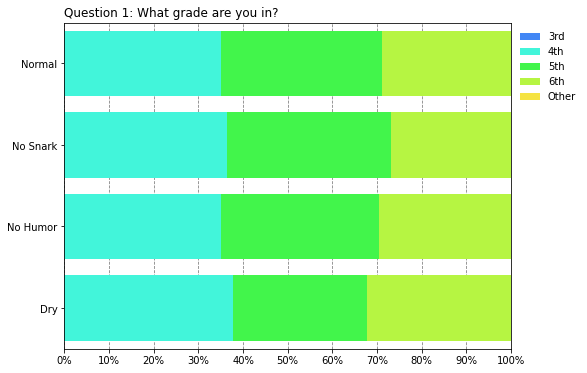

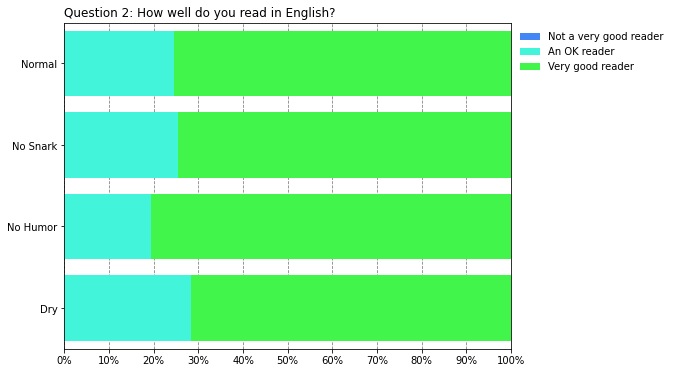

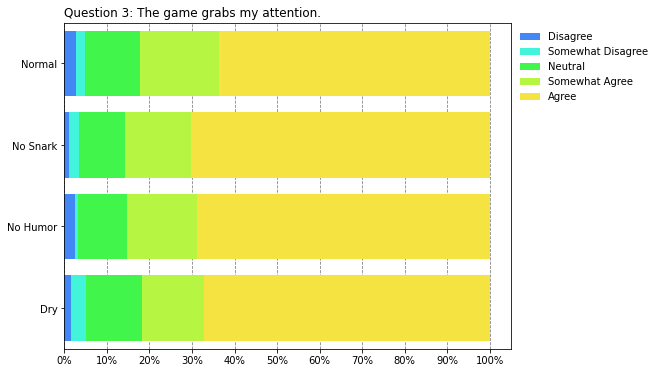

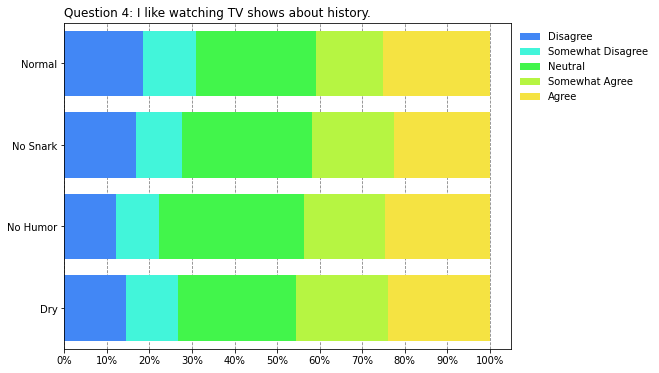

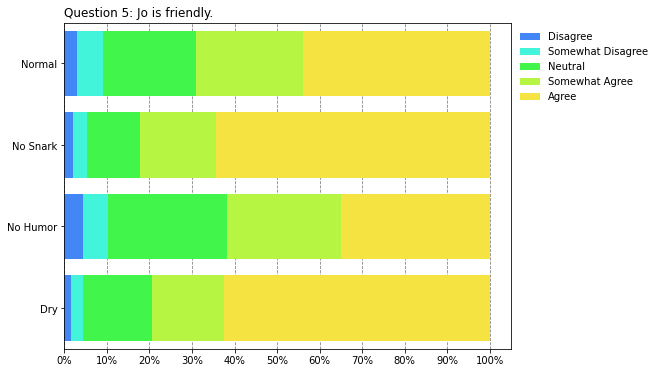

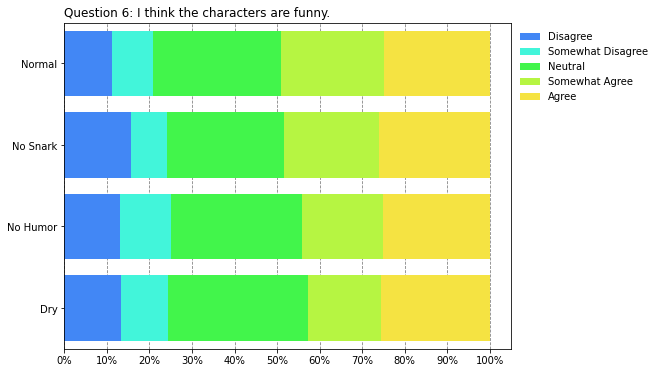

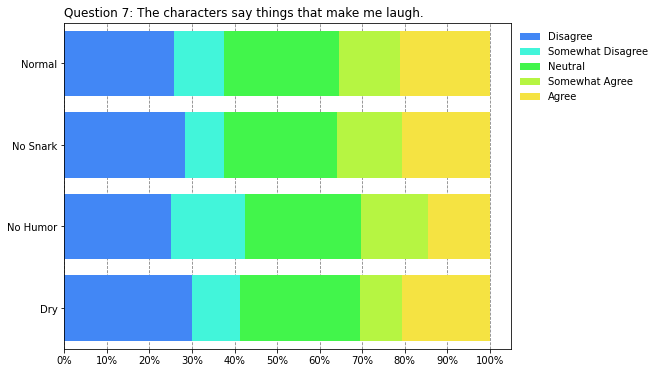

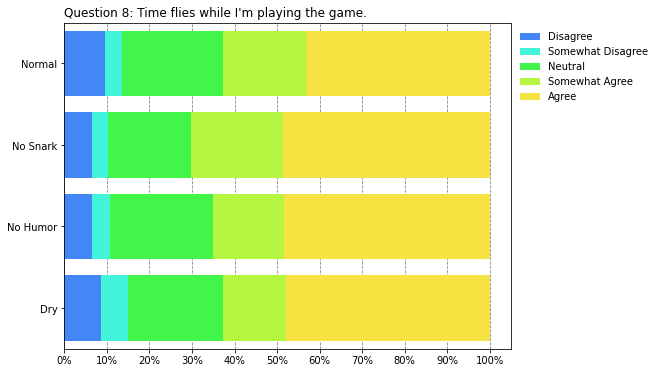

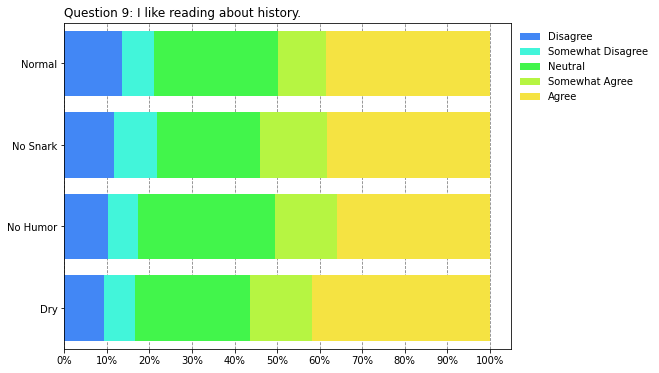

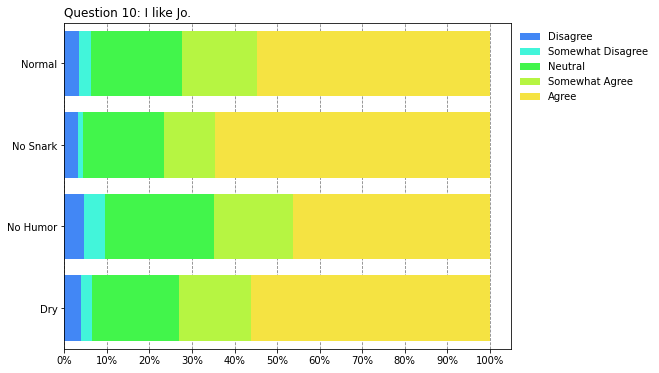

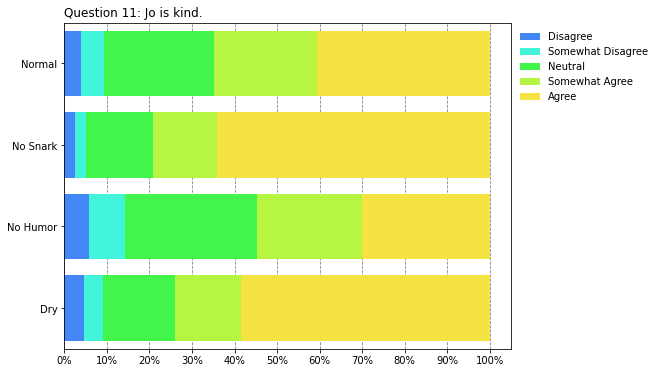

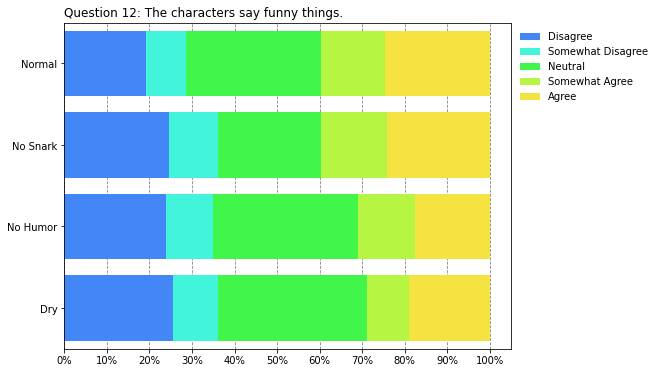

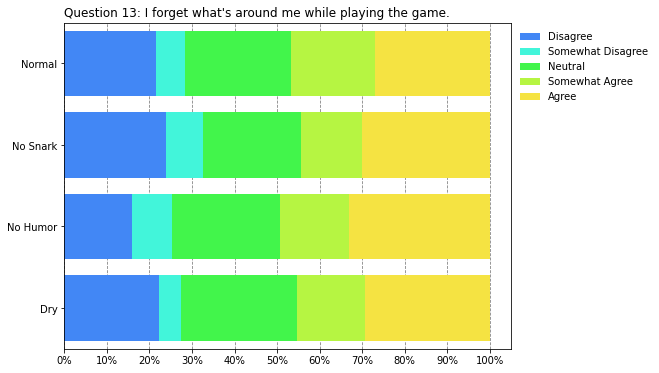

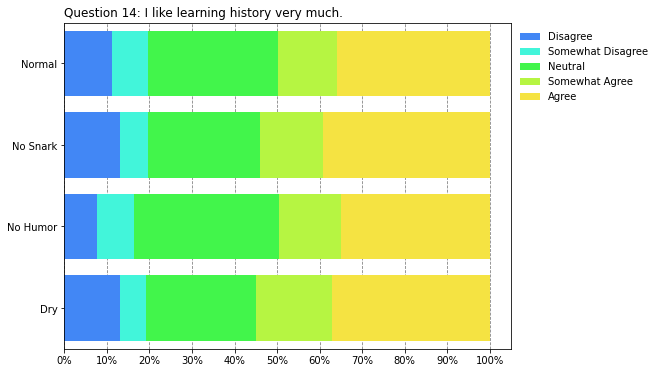

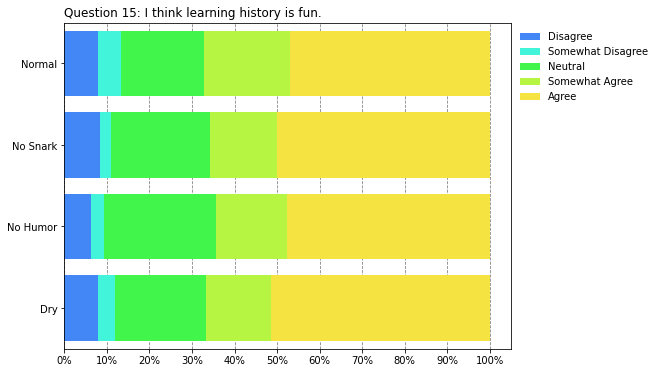

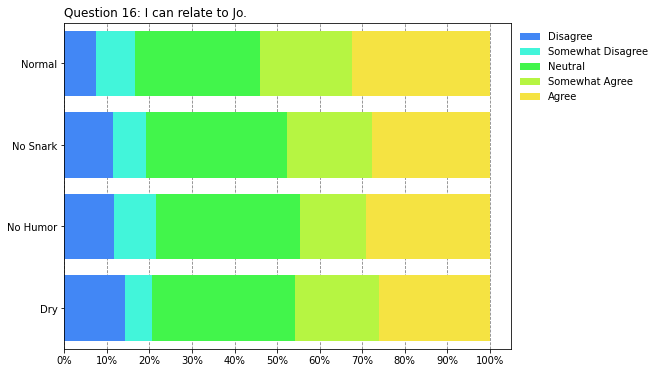

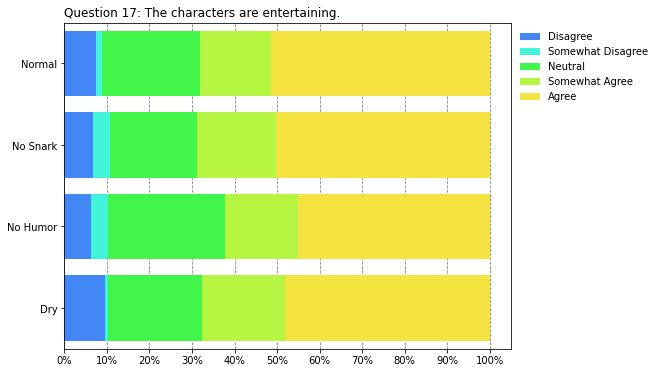

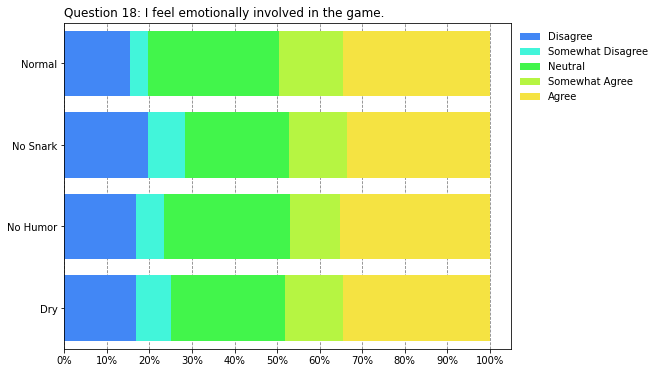

In [ ]:
completed_avgs = find_averages(c_groups)
num = 0

for i in range(0, len(completed_avgs.columns.tolist()), 5):
  response_pct_plot(completed_avgs, headers[i:i+5], num)
  num += 1

**Initial Observations**
- Survey responses don't seem to be affected by completion

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


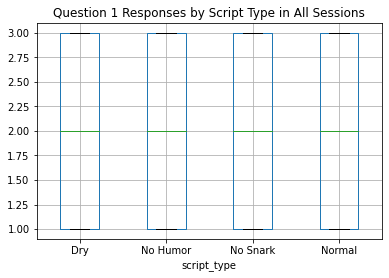

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


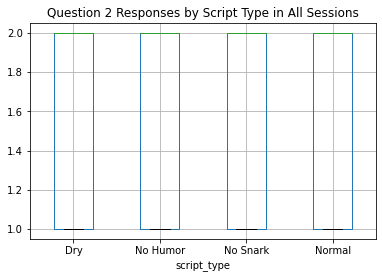

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


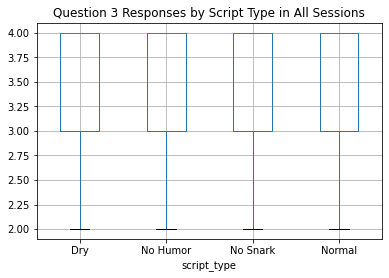

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


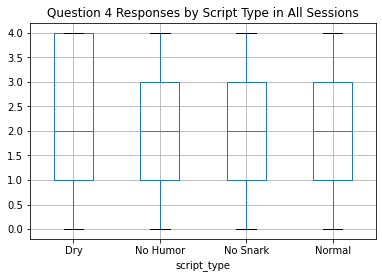

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


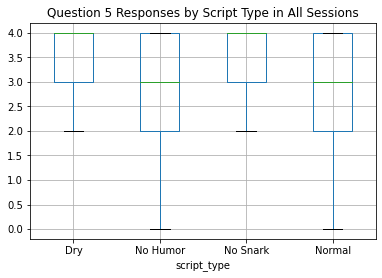

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


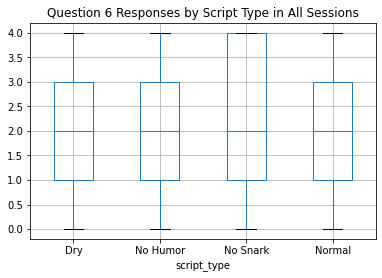

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


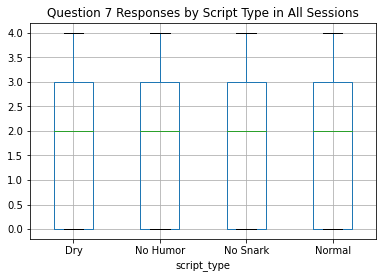

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


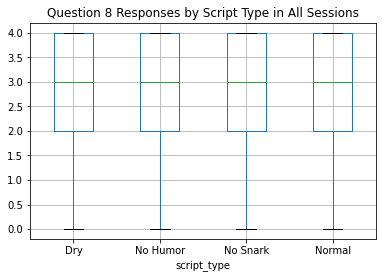

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


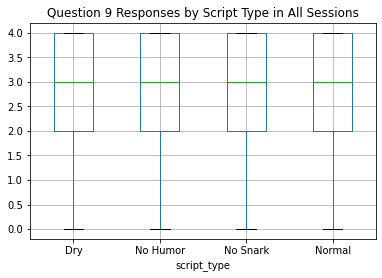

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


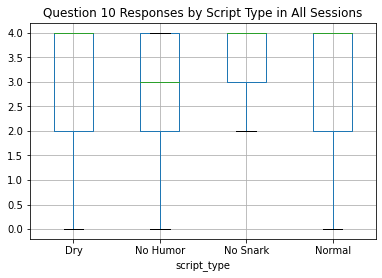

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


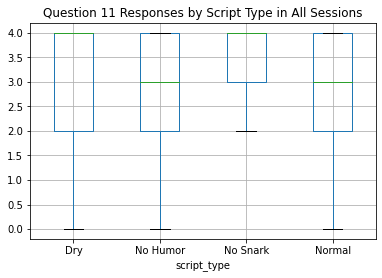

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


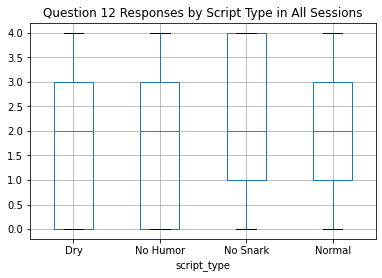

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


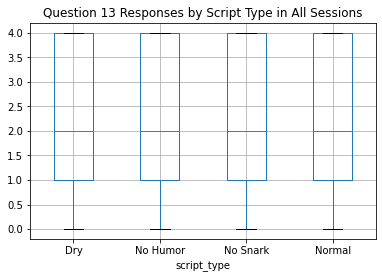

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


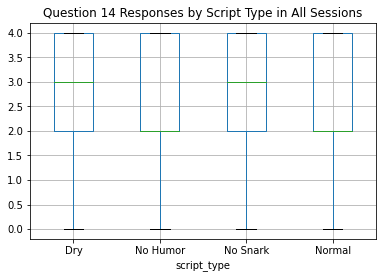

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


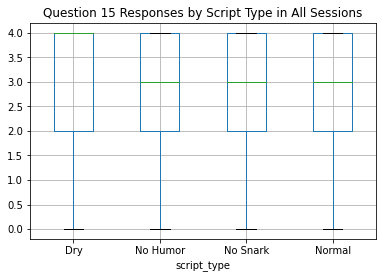

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


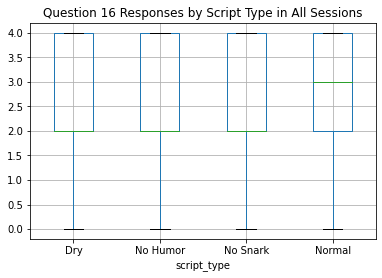

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


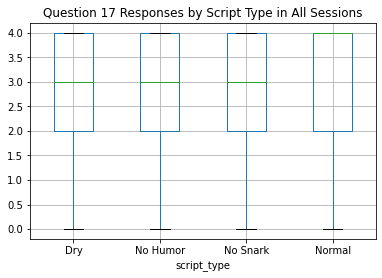

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


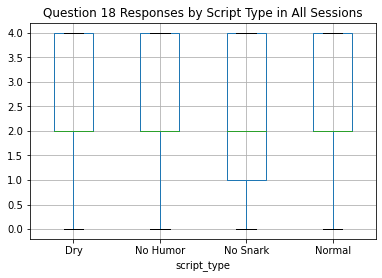

In [ ]:
for i in range(0, len(questions)):
  df.boxplot(column=f'SA{i}_sa_index', by='script_type', showfliers=False)
  plt.suptitle('')
  plt.title(f'Question {i+1} Responses by Script Type in All Sessions')
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


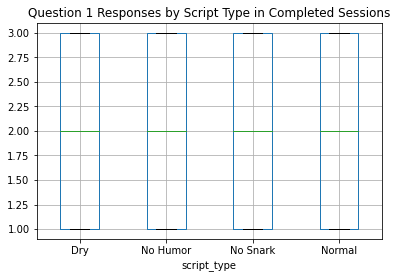

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


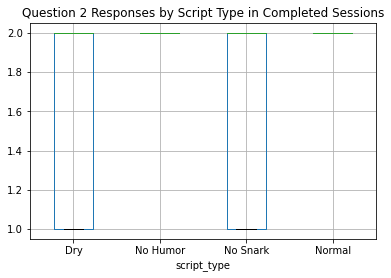

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


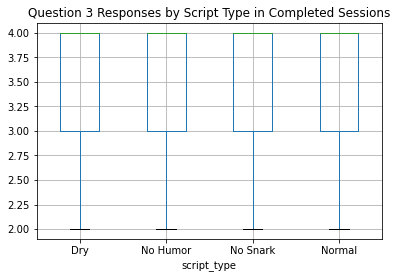

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


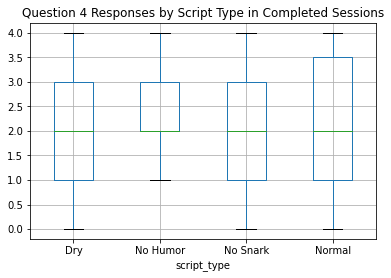

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


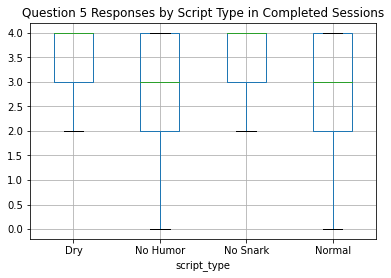

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


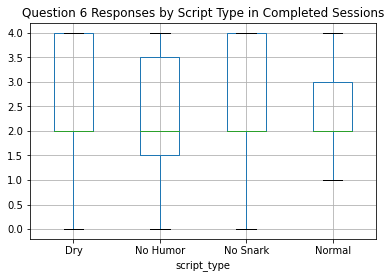

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


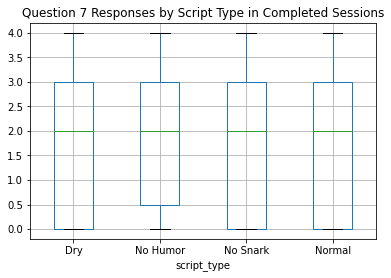

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


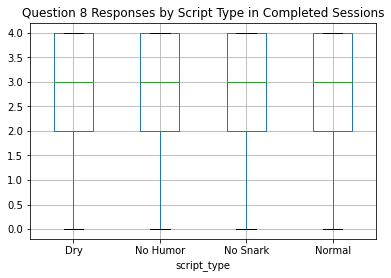

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


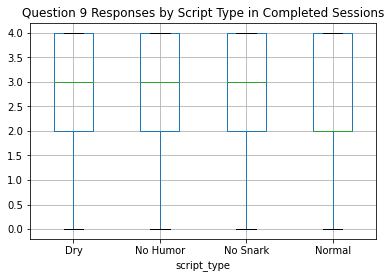

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


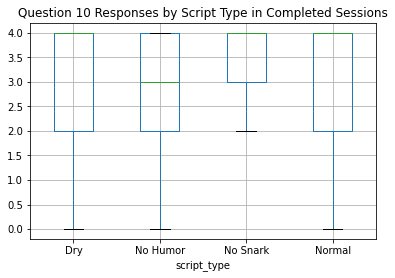

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


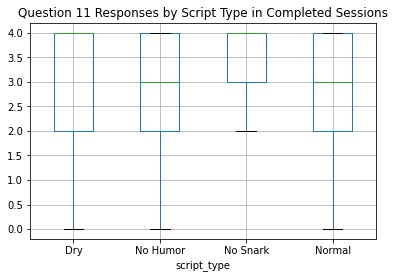

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


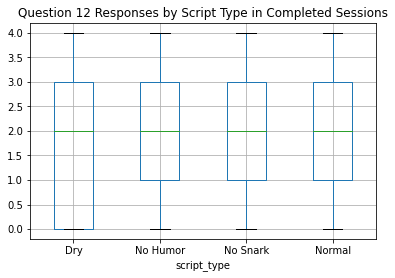

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


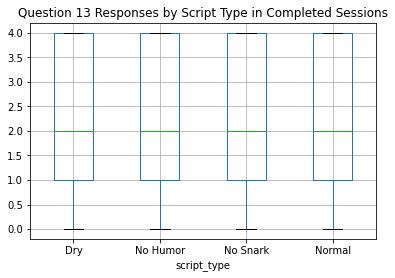

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


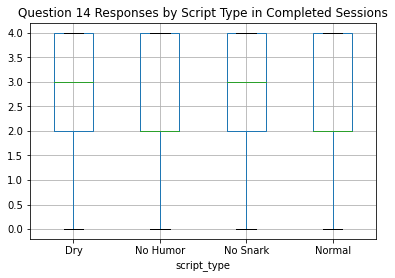

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


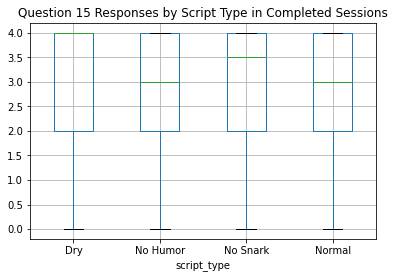

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


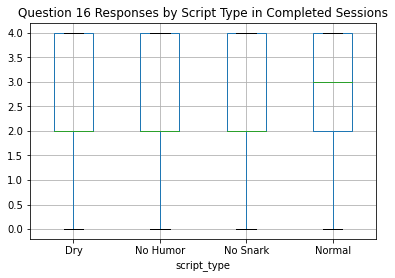

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


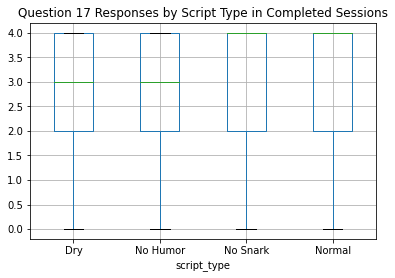

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


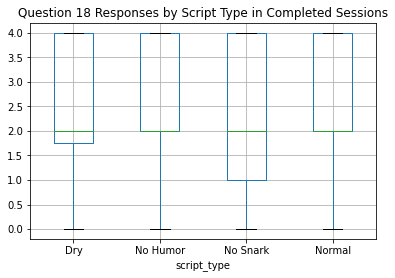

In [ ]:
for i in range(0, len(questions)):
  completed.boxplot(column=f'SA{i}_sa_index', by='script_type', showfliers=False)
  plt.suptitle('')
  plt.title(f'Question {i+1} Responses by Script Type in Completed Sessions')
  plt.show()

# Script vs. Game Time and Completion ANOVAs

In [ ]:
print('ANOVA: ', stats.f_oneway(df['sess_time_active'][df['script_type'] == 'Dry'],
               df['sess_time_active'][df['script_type'] == 'No Humor'],
               df['sess_time_active'][df['script_type'] == 'No Snark'],
               df['sess_time_active'][df['script_type'] == 'Normal']), '\n')

print('Tukey: ', pairwise_tukeyhsd(endog=df['sess_time_active'], groups=df['script_type'], alpha=0.05))

ANOVA:  F_onewayResult(statistic=4.4983945600982835, pvalue=0.003708983052454053) 

Tukey:      Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj    lower    upper   reject
-----------------------------------------------------------
     Dry No Humor -70.0731 0.0765 -144.9729   4.8268  False
     Dry No Snark   8.0797    0.9  -66.5455  82.7048  False
     Dry   Normal  32.8324 0.6574   -42.606 108.2709  False
No Humor No Snark  78.1528 0.0376    3.0747 153.2308   True
No Humor   Normal 102.9055 0.0028    27.019 178.7921   True
No Snark   Normal  24.7528  0.813  -50.8627 100.3682  False
-----------------------------------------------------------


In [ ]:
print('ANOVA: ', stats.f_oneway(df['max_level'][df['script_type'] == 'Dry'],
                                df['max_level'][df['script_type'] == 'No Humor'],
                                df['max_level'][df['script_type'] == 'No Snark'],
                                df['max_level'][df['script_type'] == 'Normal']), '\n')

print('Tukey: ', pairwise_tukeyhsd(endog=df['max_level'], groups=df['script_type'], alpha=0.05))

ANOVA:  F_onewayResult(statistic=1.0611836966362833, pvalue=0.36428420831803143) 

Tukey:    Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     Dry No Humor  -0.4091 0.4651 -1.1308 0.3126  False
     Dry No Snark   -0.229 0.8258  -0.948 0.4901  False
     Dry   Normal   0.0273    0.9 -0.6996 0.7542  False
No Humor No Snark   0.1802    0.9 -0.5433 0.9036  False
No Humor   Normal   0.4364 0.4186 -0.2948 1.1676  False
No Snark   Normal   0.2563 0.7778 -0.4723 0.9849  False
-------------------------------------------------------


In [ ]:
print('ANOVA: ', stats.f_oneway(completed['sess_time_active'][completed['script_type'] == 'Dry'],
                                completed['sess_time_active'][completed['script_type'] == 'No Humor'],
                                completed['sess_time_active'][completed['script_type'] == 'No Snark'],
                                completed['sess_time_active'][completed['script_type'] == 'Normal']), '\n')

print('Tukey: ', pairwise_tukeyhsd(endog=completed['sess_time_active'], groups=completed['script_type'], alpha=0.05))

ANOVA:  F_onewayResult(statistic=7.403528324046817, pvalue=6.490060838087707e-05) 

Tukey:      Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj    lower    upper   reject
-----------------------------------------------------------
     Dry No Humor -39.1251  0.795 -154.3859  76.1356  False
     Dry No Snark 115.3362 0.0427    2.5986 228.0739   True
     Dry   Normal 138.0491 0.0115   22.5774 253.5208   True
No Humor No Snark 154.4614 0.0029   40.2075 268.7152   True
No Humor   Normal 177.1742  0.001   60.2217 294.1267   True
No Snark   Normal  22.7129    0.9  -91.7538 137.1796  False
-----------------------------------------------------------


# Script vs. Questions using ANOVAs


In [ ]:
def test_enjoyment(df, index):
  data = df[df[f'SA{index}_sa_index'].notna()]
  return stats.f_oneway(data[f'SA{index}_sa_index'][data['script_type'] == 'Dry'],
               data[f'SA{index}_sa_index'][data['script_type'] == 'No Humor'],
               data[f'SA{index}_sa_index'][data['script_type'] == 'No Snark'],
               data[f'SA{index}_sa_index'][data['script_type'] == 'Normal'])

# ANOVA test of survey responses in all sessions
for i in range(0, len(questions)):
  print(f'Question {i+1}: ', test_enjoyment(df, i))

Question 1:  F_onewayResult(statistic=0.21871599917031903, pvalue=0.8834612744289234)
Question 2:  F_onewayResult(statistic=1.3281675722999187, pvalue=0.2632772881160018)
Question 3:  F_onewayResult(statistic=5.426317584518888, pvalue=0.0010094015170115504)
Question 4:  F_onewayResult(statistic=0.5706355810593603, pvalue=0.6343264737635489)
Question 5:  F_onewayResult(statistic=61.99691931915542, pvalue=4.281225633394483e-39)
Question 6:  F_onewayResult(statistic=6.4391222754032045, pvalue=0.0002405364924511554)
Question 7:  F_onewayResult(statistic=2.5396637522130368, pvalue=0.054922216305687374)
Question 8:  F_onewayResult(statistic=1.1217087730476132, pvalue=0.3389878195948879)
Question 9:  F_onewayResult(statistic=0.2965135526036914, pvalue=0.8279443285881759)
Question 10:  F_onewayResult(statistic=6.274475182824205, pvalue=0.00031129241902596444)
Question 11:  F_onewayResult(statistic=25.60933998679136, pvalue=3.745189811912317e-16)
Question 12:  F_onewayResult(statistic=4.7106241

In [ ]:
# ANOVA test of survey responses in completed sessions
for i in range(0, len(questions)):
  print(f'Question {i+1}: ', test_enjoyment(completed, i))

Question 1:  F_onewayResult(statistic=0.1630717890321191, pvalue=0.9212308278278533)
Question 2:  F_onewayResult(statistic=2.1554679791680784, pvalue=0.09161082850227414)
Question 3:  F_onewayResult(statistic=1.0995722035966757, pvalue=0.3483386447534858)
Question 4:  F_onewayResult(statistic=0.8559706879636619, pvalue=0.4634994407744656)
Question 5:  F_onewayResult(statistic=18.141233555048228, pvalue=1.8208695746144782e-11)
Question 6:  F_onewayResult(statistic=0.38879503899711476, pvalue=0.7611009845995408)
Question 7:  F_onewayResult(statistic=0.6962350514976755, pvalue=0.5544399808263123)
Question 8:  F_onewayResult(statistic=1.1297154178589657, pvalue=0.33599702100974915)
Question 9:  F_onewayResult(statistic=0.794969518809446, pvalue=0.4967750260134054)
Question 10:  F_onewayResult(statistic=4.607866012446353, pvalue=0.0032952816707264546)
Question 11:  F_onewayResult(statistic=19.18731952587817, pvalue=4.391521479273187e-12)
Question 12:  F_onewayResult(statistic=2.161946683833

In [ ]:
def tukey_test(df, index):
  data = df[df[f'SA{index}_sa_index'].notna()]
  return pairwise_tukeyhsd(endog=data[f'SA{index}_sa_index'], groups=data['script_type'], alpha=0.05)

# Tukeys's test of survey responses in all sessions
for i in range(0, len(questions)):
  print(f'Question {i+1}: {questions[i]}\n', tukey_test(df, i), '\n')

Question 1: What grade are you in?
   Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     Dry No Humor   0.0121    0.9  -0.071 0.0952  False
     Dry No Snark   0.0009    0.9 -0.0819 0.0837  False
     Dry   Normal   0.0229 0.8902 -0.0608 0.1066  False
No Humor No Snark  -0.0112    0.9 -0.0944 0.0721  False
No Humor   Normal   0.0108    0.9 -0.0733  0.095  False
No Snark   Normal    0.022    0.9 -0.0619 0.1059  False
------------------------------------------------------- 

Question 2: How well do you read in English?
   Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     Dry No Humor   0.0199 0.7003 -0.0292 0.0691  False
     Dry No Snark   0.0188  0.732 -0.0302 0.0677  False
     Dry   Normal   0.0384 0.1901 -0.0111 0.0879  False
No Humor No Snark  -

In [ ]:
# Tukey's test of survey responses in completed sessions
for i in range(0, len(questions)):
  print(f'Question {i+1}: {questions[i]}\n', tukey_test(completed, i), '\n')

Question 1: What grade are you in?
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj  lower  upper  reject
------------------------------------------------------
     Dry No Humor  -0.0029   0.9 -0.1756 0.1699  False
     Dry No Snark  -0.0403   0.9 -0.2093 0.1287  False
     Dry   Normal  -0.0068   0.9 -0.1799 0.1662  False
No Humor No Snark  -0.0374   0.9 -0.2087 0.1338  False
No Humor   Normal   -0.004   0.9 -0.1793 0.1713  False
No Snark   Normal   0.0334   0.9 -0.1381  0.205  False
------------------------------------------------------ 

Question 2: How well do you read in English?
   Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     Dry No Humor   0.0897  0.061 -0.0027 0.1822  False
     Dry No Snark   0.0292 0.8181 -0.0611 0.1195  False
     Dry   Normal   0.0369 0.7106 -0.0558 0.1296  False
No Humor No Snark  -0.0605 0.3

# Completion Rates per Reading Level by Grade

# New Section

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


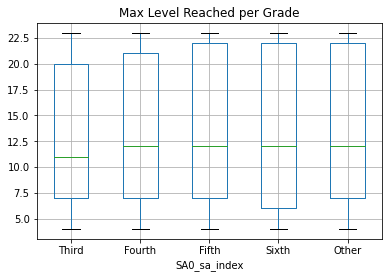

In [ ]:
all_grades.boxplot(column='max_level', by='SA0_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached per Grade')
plt.xticks([1.0, 2.0, 3.0, 4.0, 5.0], ['Third', 'Fourth', 'Fifth', 'Sixth', 'Other'])
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


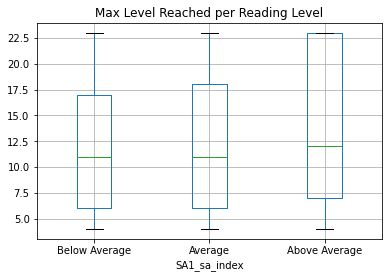

In [ ]:
all_grades.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached per Reading Level')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

In [ ]:
level_labels = {0.0: 'Below Average', 1.0: 'Average', 2.0: 'Above Average'}

# Filter to create dataframes for each grade level
third_filter = all_grades['SA0_sa_index'] == 0.0
third = all_grades[third_filter]

fourth_filter = all_grades['SA0_sa_index'] == 1.0
fourth = all_grades[fourth_filter]

fifth_filter = all_grades['SA0_sa_index'] == 2.0
fifth = all_grades[fifth_filter]

sixth_filter = all_grades['SA0_sa_index'] == 3.0
sixth = all_grades[sixth_filter]

other_filter = all_grades['SA0_sa_index'] == 4.0
other = all_grades[other_filter]

grades = [third, fourth, fifth, sixth, other]

In [ ]:
print(f'Third Grade Sessions: {third.shape[0]}')
print(f'Fourth Grade Sessions: {fourth.shape[0]}')
print(f'Fifth Grade Sessions: {fifth.shape[0]}')
print(f'Sixth Grade Sessions: {sixth.shape[0]}')
print(f'\"Other\" Grade Sessions: {other.shape[0]}')

Third Grade Sessions: 2503
Fourth Grade Sessions: 1904
Fifth Grade Sessions: 1843
Sixth Grade Sessions: 1553
"Other" Grade Sessions: 1939


Third Grade Completion:
	Below Average Percent Completion: 15.67%
	Average Percent Completion: 15.85%
	Above Average Percent Completion: 24.20%




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


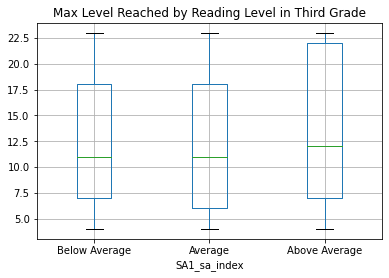

In [ ]:
third_levels = third.groupby('SA1_sa_index')
print('Third Grade Completion:')

for key, item in third_levels:
    print(f'\t{level_labels[key]} Percent Completion: {pct_completion(third_levels.get_group(key)):.2f}%')

print('\n')
third.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached by Reading Level in Third Grade')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

Fourth Grade Completion:
	Below Average Percent Completion: 9.86%
	Average Percent Completion: 20.97%
	Above Average Percent Completion: 26.07%




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


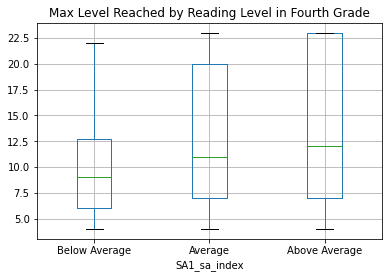

In [ ]:
fourth_levels = fourth.groupby('SA1_sa_index')
print('Fourth Grade Completion:')

for key, item in fourth_levels:
    print(f'\t{level_labels[key]} Percent Completion: {pct_completion(fourth_levels.get_group(key)):.2f}%')

print('\n')
fourth.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached by Reading Level in Fourth Grade')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

Fifth Grade Completion:
	Below Average Percent Completion: 15.15%
	Average Percent Completion: 17.57%
	Above Average Percent Completion: 27.10%




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


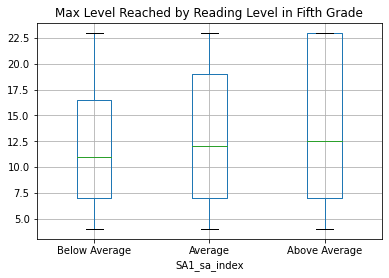

In [ ]:
fifth_levels = fifth.groupby('SA1_sa_index')
print('Fifth Grade Completion:')

for key, item in fifth_levels:
    print(f'\t{level_labels[key]} Percent Completion: {pct_completion(fifth_levels.get_group(key)):.2f}%')

print('\n')
fifth.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached by Reading Level in Fifth Grade')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

Sixth Grade Completion:
	Below Average Percent Completion: 13.89%
	Average Percent Completion: 14.16%
	Above Average Percent Completion: 28.62%




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


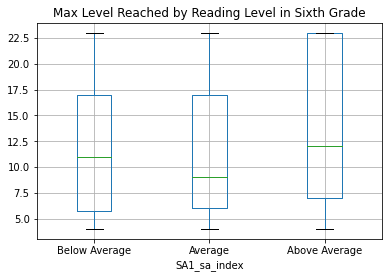

In [ ]:
sixth_levels = sixth.groupby('SA1_sa_index')
print('Sixth Grade Completion:')

for key, item in sixth_levels:
    print(f'\t{level_labels[key]} Percent Completion: {pct_completion(sixth_levels.get_group(key)):.2f}%')

print('\n')
sixth.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached by Reading Level in Sixth Grade')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

"Other" Grade Completion:
	Below Average Percent Completion: 13.95%
	Average Percent Completion: 16.96%
	Above Average Percent Completion: 28.43%




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


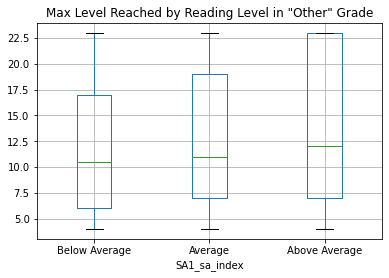

In [ ]:
other_levels = other.groupby('SA1_sa_index')
print('\"Other\" Grade Completion:')

for key, item in other_levels:
    print(f'\t{level_labels[key]} Percent Completion: {pct_completion(other_levels.get_group(key)):.2f}%')

print('\n')
other.boxplot(column='max_level', by='SA1_sa_index', showfliers=False)
plt.suptitle('')
plt.title(f'Max Level Reached by Reading Level in \"Other\" Grade')
plt.xticks([1.0, 2.0, 3.0], ['Below Average', 'Average', 'Above Average'])
plt.show()

# Liking vs Disliking TV Shows About History

In [ ]:
like_history_filter = df['SA3_sa_index'] == 4.0
like_history = df[like_history_filter]
print(f'Like History Sessions: {like_history.shape[0]}')
print(f"Like History Completion: {pct_completion(like_history):.2f}%\n")
like_history = like_history.groupby('script_type')

like_avgs = find_averages(like_history)

dislike_history_filter = df['SA3_sa_index'] == 0.0
dislike_history = df[dislike_history_filter]
print(f'Dislike History Sessions: {dislike_history.shape[0]}')
print(f"Dislike History Completion: {pct_completion(dislike_history):.2f}%")
dislike_history = dislike_history.groupby('script_type')

dislike_avgs = find_averages(dislike_history)

Like History Sessions: 870
Like History Completion: 27.59%

Dislike History Sessions: 635
Dislike History Completion: 24.41%


Like History:


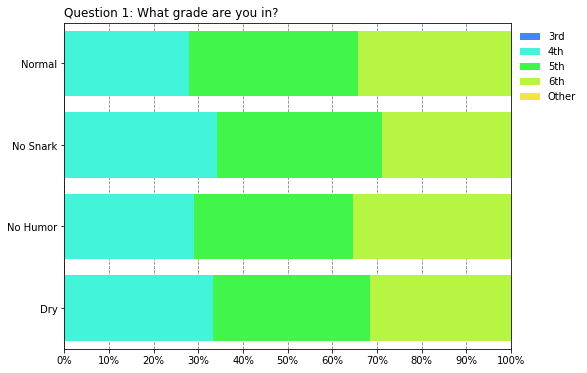

Dislike History:


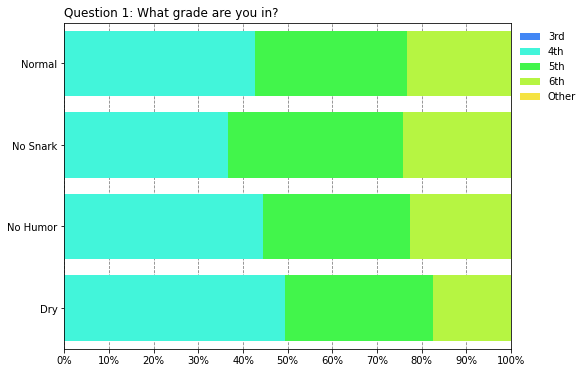

Like History:


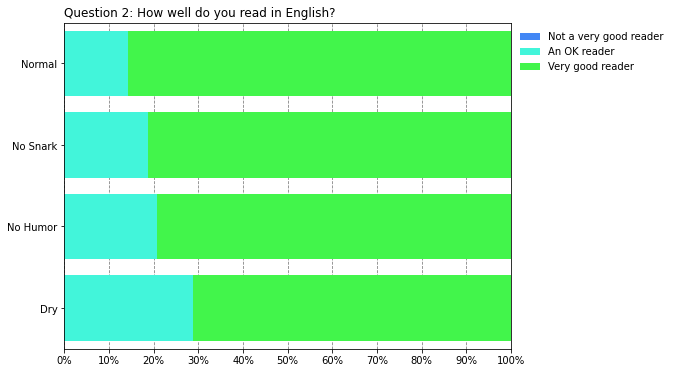

Dislike History:


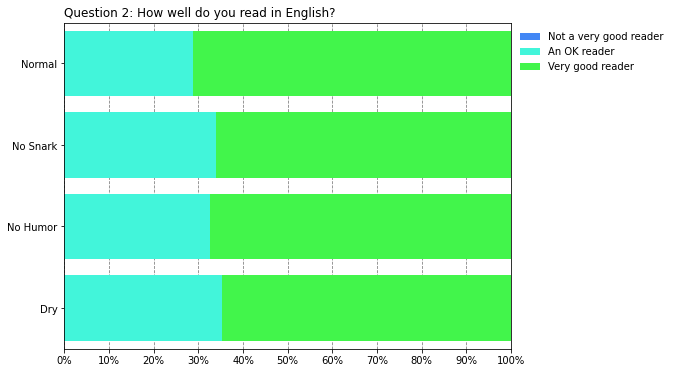

Like History:


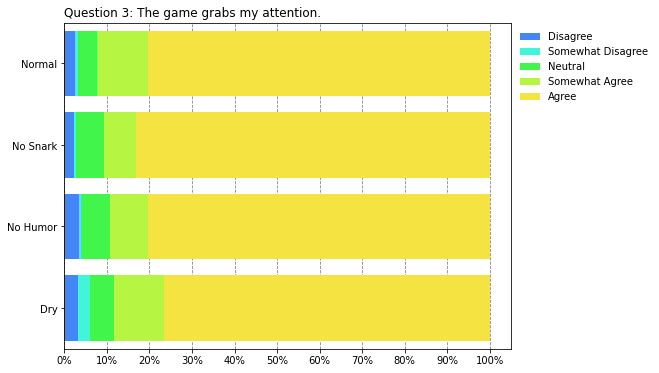

Dislike History:


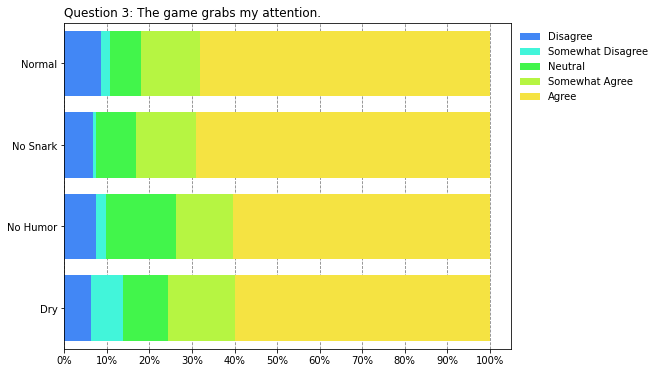

Like History:


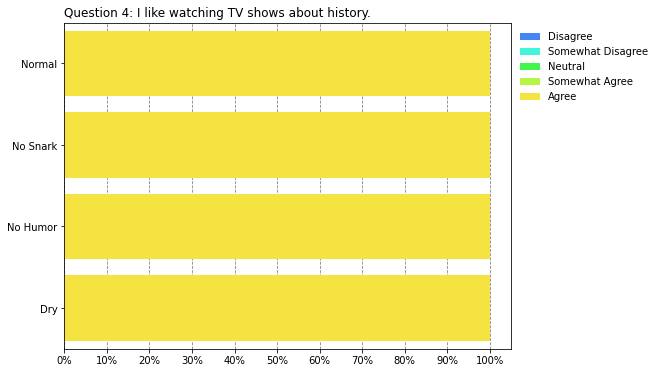

Dislike History:


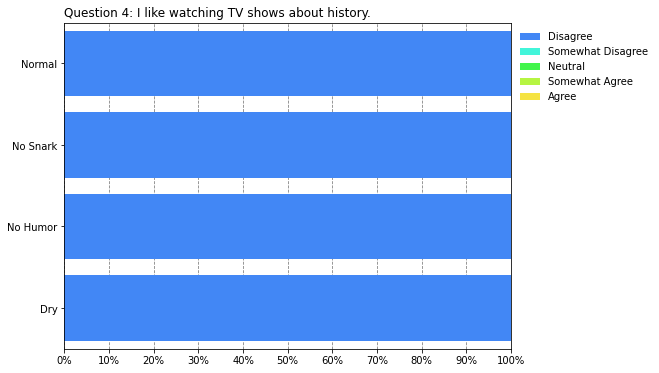

Like History:


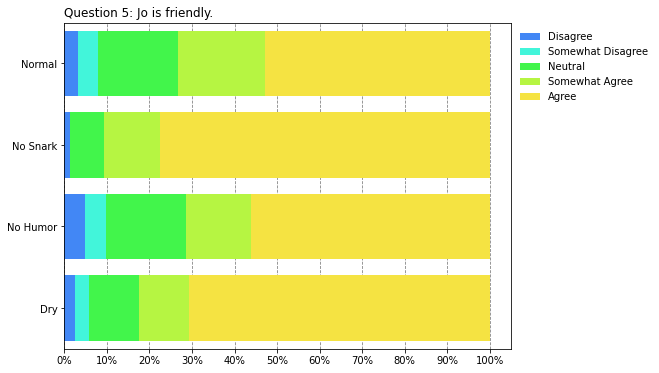

Dislike History:


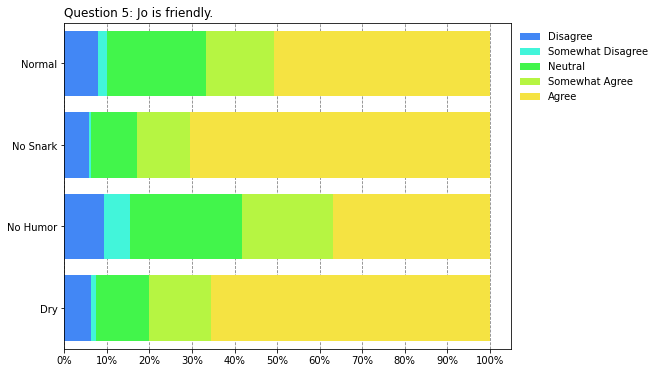

Like History:


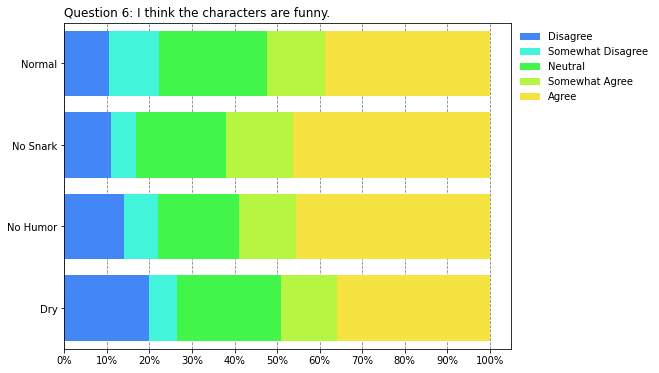

Dislike History:


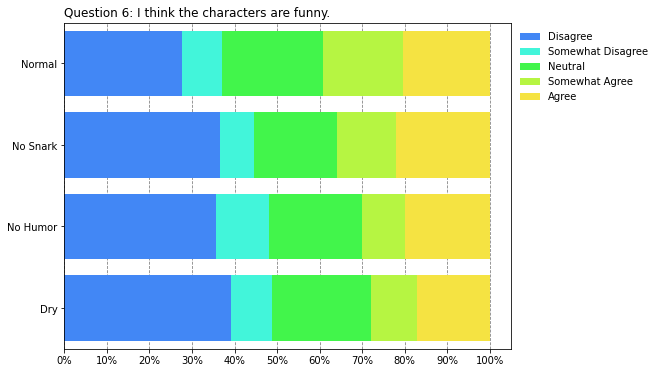

Like History:


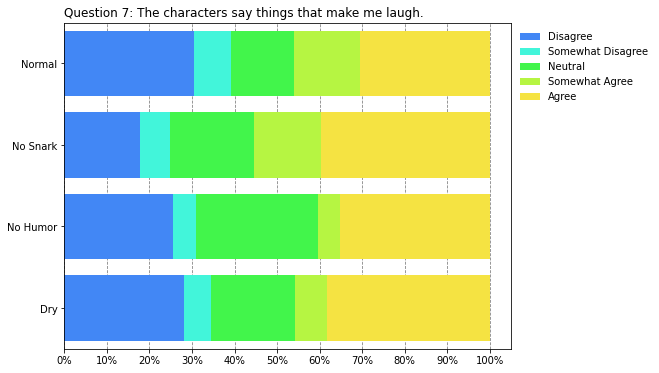

Dislike History:


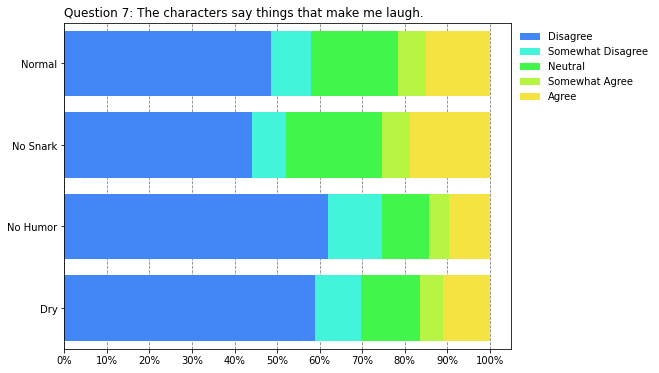

Like History:


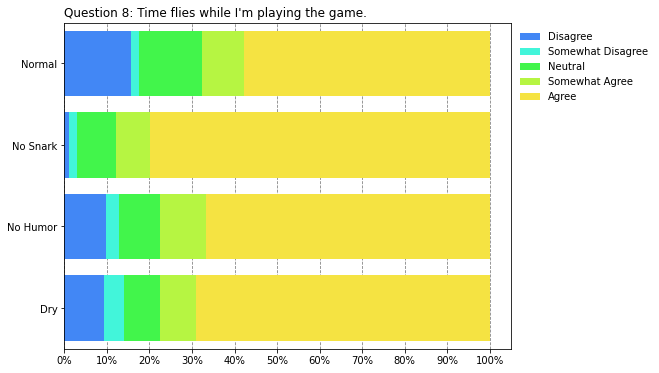

Dislike History:


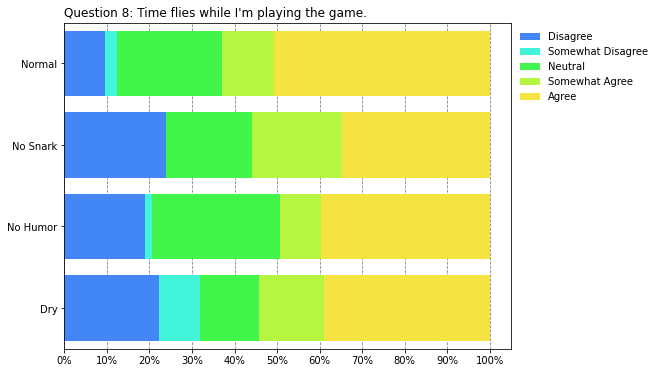

Like History:


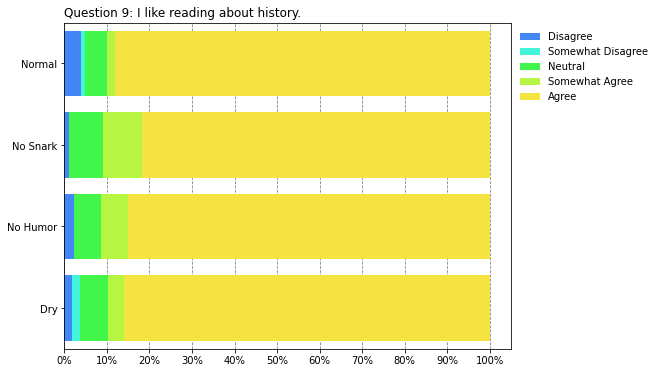

Dislike History:


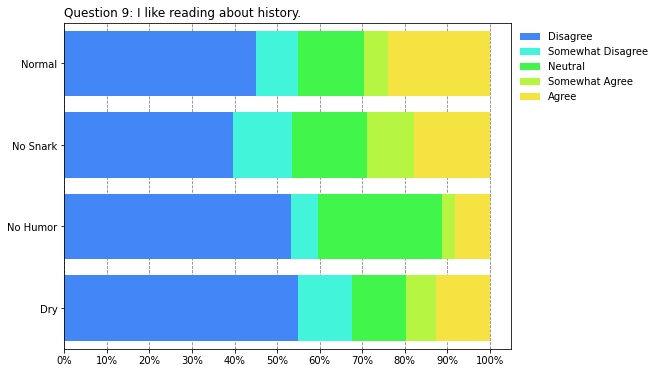

Like History:


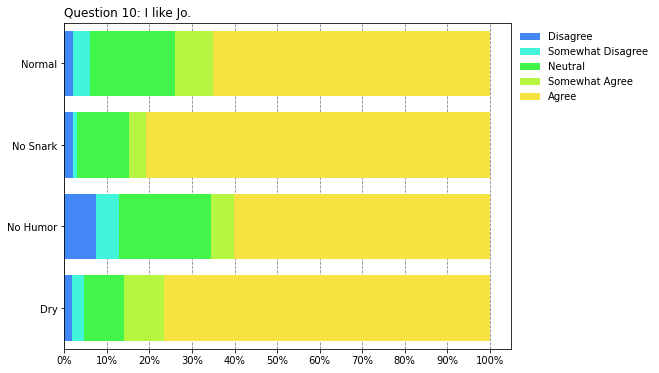

Dislike History:


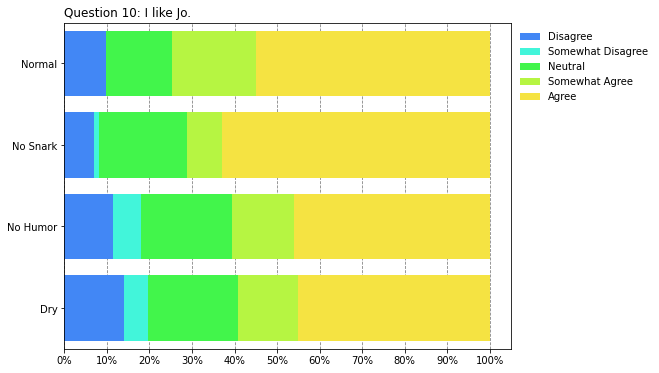

Like History:


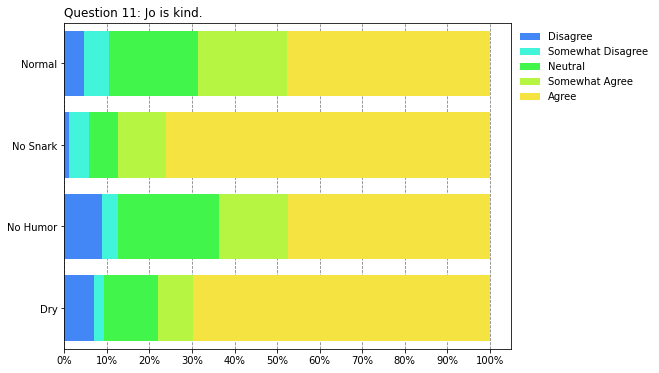

Dislike History:


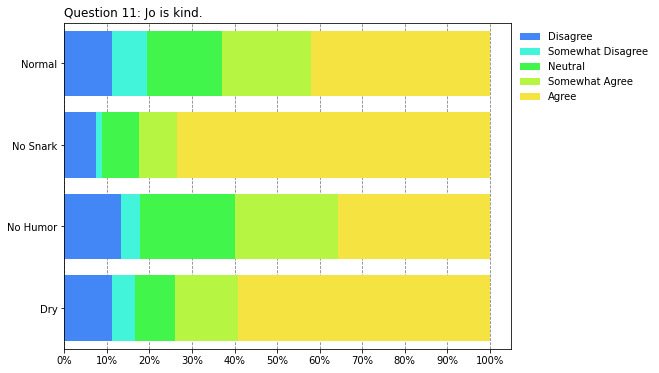

Like History:


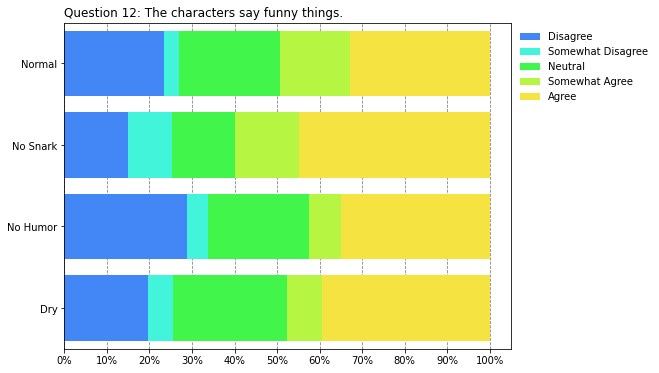

Dislike History:


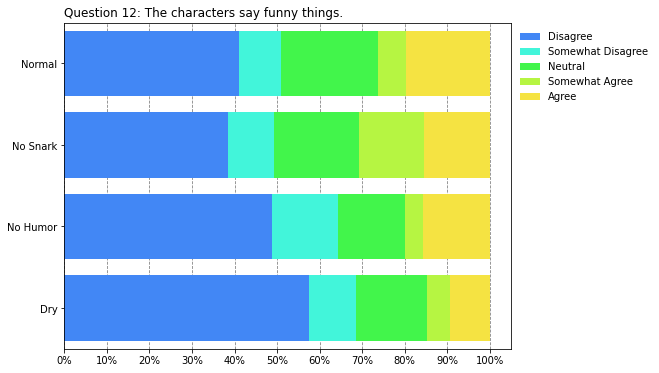

Like History:


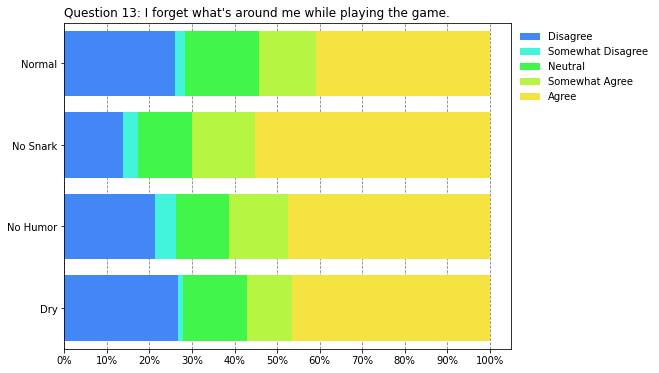

Dislike History:


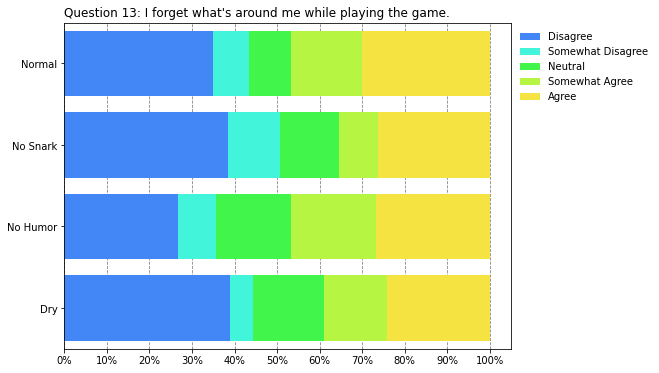

Like History:


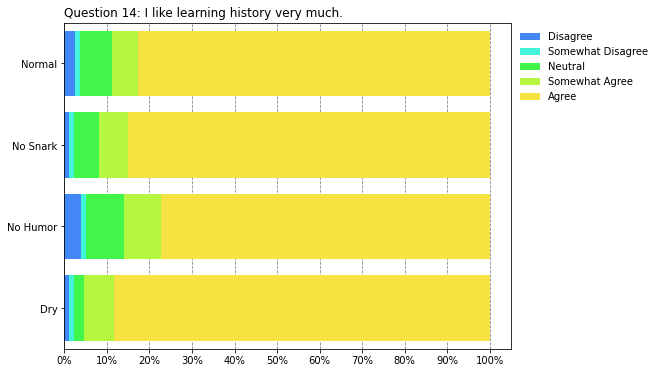

Dislike History:


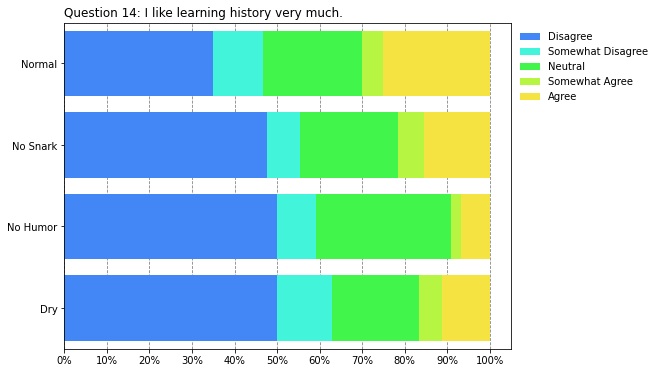

Like History:


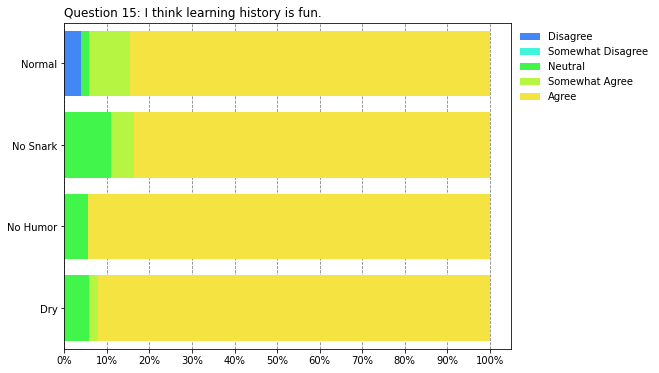

Dislike History:


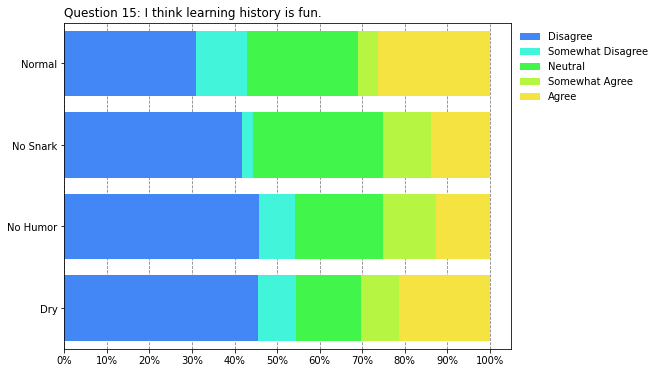

Like History:


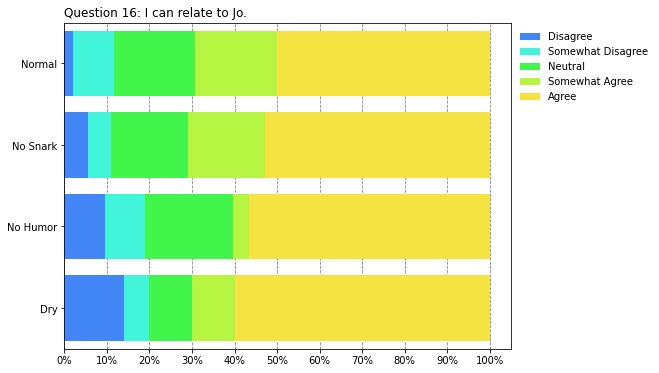

Dislike History:


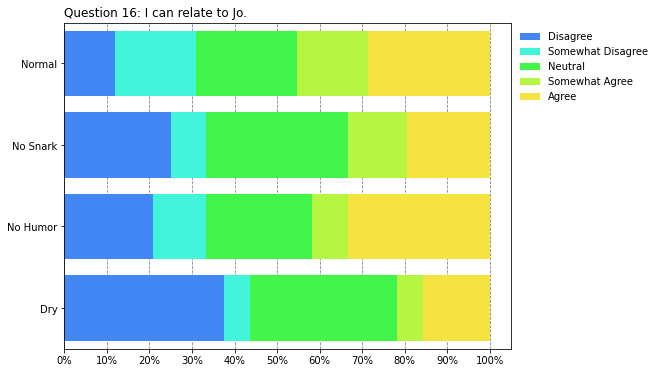

Like History:


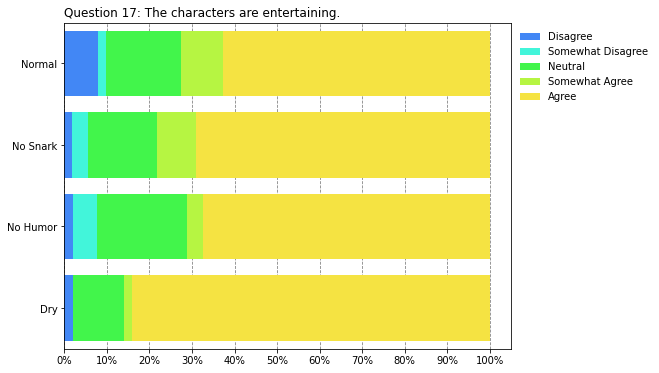

Dislike History:


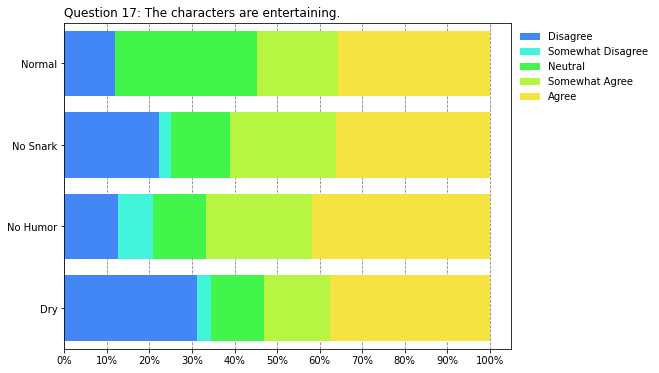

Like History:


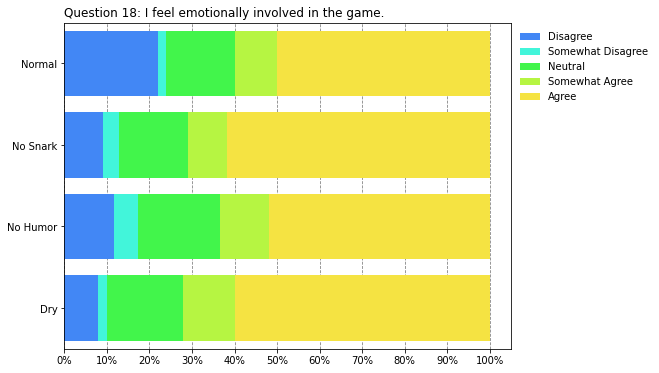

Dislike History:


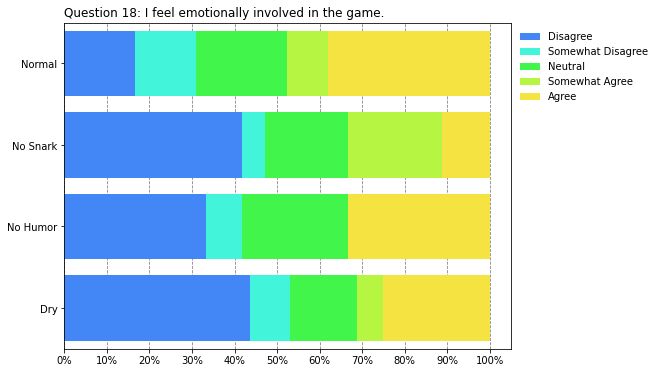

In [ ]:
num = 0

for i in range(0, len(headers), 5):
  print('Like History:')
  response_pct_plot(like_avgs, headers[i:i+5], num)
  print('Dislike History:')
  response_pct_plot(dislike_avgs, headers[i:i+5], num)
  num += 1

# Calculating Regressions in R

Enjoyment (index 2, 7, 12, 17):
- The game grabs my attention.
- Time flies while I'm playing the game.
- I forget what's around me while playing the game.
- I feel emotionally involved in the game.

History (index 3, 8, 13, 14):
- I like watching TV shows about history.
- I like reading about history.
- I like learning history very much.
- I think learning history is fun.

Likability (index 4, 9, 10, 15):
- Jo is friendly.
- I like Jo.
- Jo is kind.
- I can relate to Jo.

Humor (index 5, 6, 11, 16):
- I think the characters are funny.
- The characters say things that make me laugh.
- The characters say funny things.
- The characters are entertaining.

(see https://docs.google.com/document/d/1lavYFQzQm99sGVd1TiymTh3JJVFsCcSlByg1oNPGqRM/edit)

In [ ]:
#all_grades.to_csv('Data/new_alpha.csv')
"""
all_grades['enjoyment_score'] = all_grades[['SA2_sa_index', 'SA7_sa_index', 'SA12_sa_index', 'SA17_sa_index']].mean(axis=1)
all_grades['history_score'] = all_grades[['SA3_sa_index', 'SA8_sa_index', 'SA13_sa_index', 'SA14_sa_index']].mean(axis=1)
all_grades['likability_score'] = all_grades[['SA4_sa_index', 'SA9_sa_index', 'SA10_sa_index', 'SA15_sa_index']].mean(axis=1)
all_grades['humor_score'] = all_grades[['SA5_sa_index', 'SA6_sa_index', 'SA11_sa_index', 'SA16_sa_index']].mean(axis=1)
"""
all_grades = all_grades[all_grades['SA5_sa_index'].notnull()]
all_grades['enjoyment_score'] = all_grades[['SA2_sa_index']].mean(axis=1)
all_grades['history_score'] = all_grades[['SA3_sa_index']].mean(axis=1)
all_grades['likability_score'] = all_grades[['SA4_sa_index']].mean(axis=1)
all_grades['humor_score'] = all_grades[['SA5_sa_index']].mean(axis=1)


all_grades['enjoyment_score'] -= 2
all_grades['history_score'] -= 2
all_grades['likability_score'] -= 2
all_grades['humor_score'] -= 2

all_grades['completion'] = np.where(all_grades['max_level'] == 23, 1.0, 0.0)

#display(all_grades[['enjoyment_score', 'history_score', 'likability_score', 'humor_score', 'completion']])
#print(all_grades['enjoyment_score'].value_counts())

display(all_grades[['enjoyment_score', 'SA2_sa_index', 'SA7_sa_index']])
print(all_grades['SA2_sa_index'].value_counts())
# Counts seem to be correct here (see graph of survey question 2) - not sure why the negative correlation is happening

#all_grades.to_csv('Data/filtered_alpha.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,enjoyment_score,SA2_sa_index,SA7_sa_index
0,2.0,4.0,4.0
1,2.0,4.0,NaN
9,0.0,2.0,NaN
10,2.0,4.0,NaN
11,0.0,2.0,NaN
...,...,...,...
27758,2.0,4.0,4.0
27762,2.0,4.0,NaN
27764,1.0,3.0,1.0
27765,-2.0,0.0,0.0


4.0    4467
3.0    1146
2.0     964
0.0     317
1.0     222
Name: SA2_sa_index, dtype: int64


                  Max Level  Completion     Grade  Reading Level  \
Max Level          1.000000    0.765083  0.027515       0.122969   
Completion         0.765083    1.000000  0.025023       0.104974   
Grade              0.027515    0.025023  1.000000       0.118790   
Reading Level      0.122969    0.104974  0.118790       1.000000   
Enjoyment Score    0.090088    0.069302  0.004026       0.180887   
History Score      0.018413    0.022746  0.069842       0.065351   
Likability Score   0.058326    0.025889 -0.054646       0.088383   
Humor Score        0.047831    0.041203  0.022596       0.043571   

                  Enjoyment Score  History Score  Likability Score  \
Max Level                0.090088       0.018413          0.058326   
Completion               0.069302       0.022746          0.025889   
Grade                    0.004026       0.069842         -0.054646   
Reading Level            0.180887       0.065351          0.088383   
Enjoyment Score          1.000000    

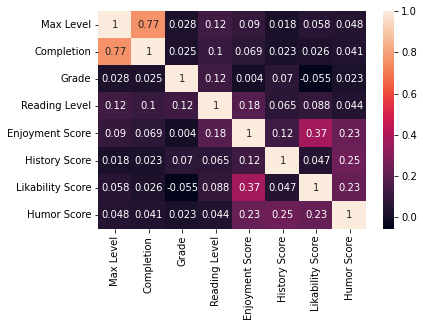

In [ ]:
c = pd.DataFrame(all_grades, columns=['script_type', 'max_level', 'completion', 'SA0_sa_index', 'SA1_sa_index', 'enjoyment_score', 'history_score', 'likability_score', 'humor_score'])
c.columns = ['Script', 'Max Level', 'Completion', 'Grade', 'Reading Level', 'Enjoyment Score', 'History Score', 'Likability Score', 'Humor Score']

corr_matrix = c.corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(tidyverse)
install.packages("psych")
library(psych)

df2 = read_csv('Data/new_alpha.csv')

enjoyment = df2 %>% select(SA2_sa_index, SA7_sa_index, SA12_sa_index, SA17_sa_index)
history = df2 %>% select(SA3_sa_index, SA8_sa_index, SA13_sa_index, SA14_sa_index)
likability = df2 %>% select(SA4_sa_index, SA9_sa_index, SA10_sa_index, SA15_sa_index)
humor = df2 %>% select(SA5_sa_index, SA6_sa_index, SA11_sa_index, SA16_sa_index)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘tmvnsim’, ‘mnormt’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/tmvnsim_1.0-2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6052 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: 

Rows: 11804 Columns: 3553
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (19): SA0_sa_text, SA1_sa_text, SA2_sa_text, SA3_sa_text, SA4_sa_text,...
dbl (1554): ...1, lvl0_EventCount, lvl1_EventCount, lvl2_EventCount, lvl3_Ev...
lgl (1980): lvl24_EventCount, lvl25_EventCount, lvl26_EventCount, lvl27_Even...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
%%R
psych::alpha(enjoyment)


Reliability analysis   
Call: psych::alpha(x = enjoyment)

  raw_alpha std.alpha G6(smc) average_r S/N    ase mean  sd median_r
      0.62      0.62    0.56      0.29 1.6 0.0055    3 1.1     0.29

 lower alpha upper     95% confidence boundaries
0.61 0.62 0.64 

 Reliability if an item is dropped:
              raw_alpha std.alpha G6(smc) average_r S/N alpha se  var.r med.r
SA2_sa_index       0.62      0.62    0.52      0.35 1.6   0.0061 0.0023  0.35
SA7_sa_index       0.54      0.53    0.44      0.27 1.1   0.0071 0.0121  0.24
SA12_sa_index      0.55      0.55    0.45      0.29 1.2   0.0071 0.0031  0.28
SA17_sa_index      0.50      0.51    0.41      0.26 1.0   0.0078 0.0036  0.28

 Item statistics 
                 n raw.r std.r r.cor r.drop mean  sd
SA2_sa_index  7578  0.85  0.62  0.39   0.31  3.3 1.1
SA7_sa_index  3260  0.74  0.70  0.54   0.43  2.8 1.3
SA12_sa_index 2729  0.75  0.69  0.53   0.42  2.3 1.5
SA17_sa_index 1689  0.75  0.72  0.59   0.47  2.5 1.4

Non missing response freq

In [ ]:
%%R
psych::alpha(history)


Reliability analysis   
Call: psych::alpha(x = history)

  raw_alpha std.alpha G6(smc) average_r S/N    ase mean  sd median_r
      0.88      0.88    0.85      0.64 7.1 0.0019  2.3 1.4     0.64

 lower alpha upper     95% confidence boundaries
0.87 0.88 0.88 

 Reliability if an item is dropped:
              raw_alpha std.alpha G6(smc) average_r S/N alpha se   var.r med.r
SA3_sa_index       0.88      0.88    0.83      0.70 7.1   0.0020 6.8e-05  0.70
SA8_sa_index       0.83      0.83    0.77      0.62 4.8   0.0028 7.5e-03  0.59
SA13_sa_index      0.82      0.83    0.77      0.61 4.7   0.0028 6.0e-03  0.59
SA14_sa_index      0.83      0.83    0.78      0.63 5.0   0.0027 4.1e-03  0.59

 Item statistics 
                 n raw.r std.r r.cor r.drop mean  sd
SA3_sa_index  7277  0.93  0.80  0.68   0.64  2.2 1.4
SA8_sa_index  3225  0.88  0.87  0.82   0.77  2.5 1.4
SA13_sa_index 2712  0.88  0.88  0.83   0.77  2.5 1.4
SA14_sa_index 1733  0.86  0.87  0.81   0.75  2.9 1.3

Non missing response f

In [ ]:
%%R
psych::alpha(likability)


Reliability analysis   
Call: psych::alpha(x = likability)

  raw_alpha std.alpha G6(smc) average_r S/N   ase mean  sd median_r
      0.74      0.74     0.7      0.42 2.9 0.004  3.1 1.1     0.42

 lower alpha upper     95% confidence boundaries
0.73 0.74 0.75 

 Reliability if an item is dropped:
              raw_alpha std.alpha G6(smc) average_r S/N alpha se  var.r med.r
SA4_sa_index       0.69      0.69    0.60      0.43 2.3   0.0049 0.0014  0.43
SA9_sa_index       0.67      0.67    0.61      0.41 2.1   0.0054 0.0224  0.39
SA10_sa_index      0.63      0.63    0.55      0.37 1.7   0.0059 0.0076  0.40
SA15_sa_index      0.73      0.73    0.65      0.48 2.7   0.0043 0.0070  0.47

 Item statistics 
                 n raw.r std.r r.cor r.drop mean  sd
SA4_sa_index  7200  0.92  0.74  0.63   0.51  3.1 1.1
SA9_sa_index  3206  0.79  0.76  0.64   0.56  3.1 1.2
SA10_sa_index 2829  0.83  0.81  0.73   0.62  3.0 1.2
SA15_sa_index 1709  0.73  0.70  0.53   0.45  2.5 1.3

Non missing response frequ

In [ ]:
%%R
psych::alpha(humor)


Reliability analysis   
Call: psych::alpha(x = humor)

  raw_alpha std.alpha G6(smc) average_r S/N    ase mean  sd median_r
       0.8       0.8    0.76      0.49 3.9 0.0029  2.1 1.3     0.47

 lower alpha upper     95% confidence boundaries
0.79 0.8 0.81 

 Reliability if an item is dropped:
              raw_alpha std.alpha G6(smc) average_r S/N alpha se  var.r med.r
SA5_sa_index       0.75      0.75    0.70      0.50 3.0   0.0038 0.0284  0.41
SA6_sa_index       0.72      0.71    0.64      0.45 2.5   0.0044 0.0118  0.41
SA11_sa_index      0.69      0.69    0.61      0.43 2.2   0.0048 0.0072  0.39
SA16_sa_index      0.82      0.82    0.76      0.60 4.5   0.0029 0.0072  0.58

 Item statistics 
                 n raw.r std.r r.cor r.drop mean  sd
SA5_sa_index  7116  0.92  0.79  0.67   0.61  2.2 1.4
SA6_sa_index  3324  0.85  0.83  0.77   0.68  1.7 1.5
SA11_sa_index 2767  0.87  0.85  0.81   0.72  1.9 1.5
SA16_sa_index 1699  0.66  0.69  0.50   0.46  3.0 1.2

Non missing response frequency

In [ ]:
%%R
library(tidyverse)
#df = read_csv("filtered4.csv")
df = read_csv("Data/filtered_alpha.csv")
df = df %>%
  rename(
      grade_level = SA0_sa_index,
      reading_level = SA1_sa_index,
  )

factors = df %>% select(max_level, completion, script_type, grade_level, reading_level, enjoyment_score, history_score, likability_score, humor_score)

factors$script_type = factor(factors$script_type, levels=c("Normal", "No Snark", "No Humor", "Dry"))
factors$grade_level = factor(factors$grade_level, levels=c(0, 1, 2, 3, 4), labels=c("3rd", "4th", "5th", "6th", "Other"))
factors$reading_level = factor(factors$reading_level, levels=c(0, 1, 2), labels=c("Below Average", "Average", "Above Average"))

factors$reading_level = relevel(factors$reading_level, ref = "Average")

summary(factors)

R[write to console]: New names:
* `` -> ...1



Rows: 7116 Columns: 3558
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (19): SA0_sa_text, SA1_sa_text, SA2_sa_text, SA3_sa_text, SA4_sa_text,...
dbl (1567): ...1, lvl0_EventCount, lvl1_EventCount, lvl2_EventCount, lvl3_Ev...
lgl (1972): lvl24_EventCount, lvl25_EventCount, lvl26_EventCount, lvl27_Even...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
   max_level       completion      script_type   grade_level 
 Min.   : 4.00   Min.   :0.000   Normal  :1723   3rd  :1617  
 1st Qu.: 8.00   1st Qu.:0.000   No Snark:1783   4th  :1364  
 Median :12.00   Median :0.000   No Humor:1745   5th  :1355  
 Mean   :14.22   Mean   :0.257   Dry     :1865   6th  :1155  
 3rd Qu.:23.00   3rd Qu.:1.000                   Other:1357  
 Max.   :23.00   Max.   :1.000                   NA's : 268  
       reading_level  enjoyment_score  history_sco

In [ ]:
%%R
# Poisson regression on max level reached
pois = glm(max_level ~ grade_level + reading_level, data = factors, family = poisson(link="log"))
summary(pois)


Call:
glm(formula = max_level ~ grade_level + reading_level, family = poisson(link = "log"), 
    data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4567  -1.8458  -0.4328   1.8157   2.6555  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 2.5784158  0.0084924 303.613  < 2e-16 ***
grade_level4th              0.0150497  0.0098923   1.521  0.12817    
grade_level5th              0.0454264  0.0098270   4.623 3.79e-06 ***
grade_level6th              0.0001635  0.0103892   0.016  0.98744    
grade_levelOther            0.0262505  0.0098808   2.657  0.00789 ** 
reading_levelBelow Average -0.0528163  0.0133288  -3.963 7.41e-05 ***
reading_levelAbove Average  0.1075876  0.0073840  14.570  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 22754  on 6799  degrees of freedom
Residual deviance

In [ ]:
%%R
# Poisson regression on max level reached
pois = glm(max_level ~ enjoyment_score + history_score + likability_score + humor_score, data = factors, family = poisson(link="log"))
summary(pois)


Call:
glm(formula = max_level ~ enjoyment_score + history_score + likability_score + 
    humor_score, family = poisson(link = "log"), data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3639  -1.8791  -0.5344   1.9348   2.7946  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      2.5966367  0.0054831 473.572  < 2e-16 ***
enjoyment_score  0.0337856  0.0032356  10.442  < 2e-16 ***
history_score    0.0006888  0.0022642   0.304 0.760952    
likability_score 0.0105790  0.0030742   3.441 0.000579 ***
humor_score      0.0081383  0.0023517   3.461 0.000539 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 23856  on 7115  degrees of freedom
Residual deviance: 23637  on 7111  degrees of freedom
AIC: 54779

Number of Fisher Scoring iterations: 4



In [ ]:
%%R
# Poisson regression on max level reached
pois = glm(max_level ~ grade_level + reading_level + enjoyment_score + history_score + likability_score + humor_score, data = factors, family = poisson(link="log"))
summary(pois)


Call:
glm(formula = max_level ~ grade_level + reading_level + enjoyment_score + 
    history_score + likability_score + humor_score, family = poisson(link = "log"), 
    data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5683  -1.7693  -0.4426   1.7863   3.1019  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 2.5389511  0.0095750 265.165  < 2e-16 ***
grade_level4th              0.0120721  0.0098958   1.220 0.222495    
grade_level5th              0.0422635  0.0098448   4.293 1.76e-05 ***
grade_level6th              0.0006931  0.0104144   0.067 0.946940    
grade_levelOther            0.0288444  0.0099156   2.909 0.003626 ** 
reading_levelBelow Average -0.0443942  0.0133763  -3.319 0.000904 ***
reading_levelAbove Average  0.0972773  0.0074668  13.028  < 2e-16 ***
enjoyment_score             0.0276231  0.0033734   8.189 2.64e-16 ***
history_score              -0.0026093  0.0023309  -1.1

In [ ]:
%%R
# Poisson regression on max level reached
pois = glm(max_level ~ script_type + grade_level + reading_level + enjoyment_score + history_score + likability_score + humor_score, data = factors, family = poisson(link="log"))
summary(pois)


Call:
glm(formula = max_level ~ script_type + grade_level + reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = poisson(link = "log"), data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.5737  -1.7693  -0.4466   1.7904   3.0994  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 2.537e+00  1.104e-02 229.886  < 2e-16 ***
script_typeNo Snark        -8.618e-05  9.221e-03  -0.009 0.992543    
script_typeNo Humor         3.100e-03  9.204e-03   0.337 0.736280    
script_typeDry              3.474e-03  9.147e-03   0.380 0.704080    
grade_level4th              1.206e-02  9.896e-03   1.219 0.222832    
grade_level5th              4.234e-02  9.846e-03   4.300 1.71e-05 ***
grade_level6th              6.694e-04  1.041e-02   0.064 0.948751    
grade_levelOther            2.891e-02  9.917e-03   2.915 0.003558 ** 
reading_levelBelow Average -4.426e-02  1

In [ ]:
%%R
# Poisson regression of grade and reading on max level reached
pois = glm(max_level ~ grade_level + reading_level, data = factors, family = poisson(link="log"))
summary(pois)


Call:
glm(formula = max_level ~ grade_level + reading_level, family = poisson(link = "log"), 
    data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4567  -1.8458  -0.4328   1.8157   2.6555  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 2.5784158  0.0084924 303.613  < 2e-16 ***
grade_level4th              0.0150497  0.0098923   1.521  0.12817    
grade_level5th              0.0454264  0.0098270   4.623 3.79e-06 ***
grade_level6th              0.0001635  0.0103892   0.016  0.98744    
grade_levelOther            0.0262505  0.0098808   2.657  0.00789 ** 
reading_levelBelow Average -0.0528163  0.0133288  -3.963 7.41e-05 ***
reading_levelAbove Average  0.1075876  0.0073840  14.570  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 22754  on 6799  degrees of freedom
Residual deviance

In [ ]:
"""
Call:
glm(formula = max_level ~ script_type + grade_level + reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = poisson(link = "log"), data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7760  -1.7440  -0.0342   1.6434   2.7219  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 2.593358   0.009125 284.201  < 2e-16 ***
script_typeNo Snark         0.003175   0.007969   0.398 0.690291    
script_typeNo Humor         0.015233   0.007881   1.933 0.053247 .  
script_typeDry              0.026112   0.007872   3.317 0.000909 ***
grade_level4th              0.037986   0.008092   4.694 2.67e-06 ***
grade_level5th              0.075501   0.008466   8.918  < 2e-16 ***
grade_level6th              0.053208   0.008994   5.916 3.30e-09 ***
grade_levelOther            0.030262   0.008376   3.613 0.000303 ***
reading_levelBelow Average -0.019753   0.010993  -1.797 0.072365 .  
reading_levelAbove Average  0.067481   0.006319  10.678  < 2e-16 ***
enjoyment_score             0.025758   0.002726   9.449  < 2e-16 ***
history_score              -0.001892   0.001944  -0.974 0.330294    
likability_score            0.006527   0.002716   2.403 0.016263 *  
humor_score                 0.002016   0.002008   1.004 0.315559    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 29354  on 8682  degrees of freedom
Residual deviance: 28863  on 8669  degrees of freedom
  (464 observations deleted due to missingness)
AIC: 67473

Number of Fisher Scoring iterations: 4
"""

'\nCall:\nglm(formula = max_level ~ script_type + grade_level + reading_level + \n    enjoyment_score + history_score + likability_score + humor_score, \n    family = poisson(link = "log"), data = factors)\n\nDeviance Residuals: \n    Min       1Q   Median       3Q      Max  \n-3.7760  -1.7440  -0.0342   1.6434   2.7219  \n\nCoefficients:\n                            Estimate Std. Error z value Pr(>|z|)    \n(Intercept)                 2.593358   0.009125 284.201  < 2e-16 ***\nscript_typeNo Snark         0.003175   0.007969   0.398 0.690291    \nscript_typeNo Humor         0.015233   0.007881   1.933 0.053247 .  \nscript_typeDry              0.026112   0.007872   3.317 0.000909 ***\ngrade_level4th              0.037986   0.008092   4.694 2.67e-06 ***\ngrade_level5th              0.075501   0.008466   8.918  < 2e-16 ***\ngrade_level6th              0.053208   0.008994   5.916 3.30e-09 ***\ngrade_levelOther            0.030262   0.008376   3.613 0.000303 ***\nreading_levelBelow Average -

- No Humor and Dry has higher max level
- All grade levels had higher max level compared to 3rd grade
- Below average reading had lower max level than average
- Above average reading had higher max level than average

In [ ]:
%%R
pois2 = glm(max_level ~ script_type * (grade_level * reading_level + enjoyment_score + history_score + likability_score + humor_score), data = factors, family = poisson(link="log"))
summary(pois2)


Call:
glm(formula = max_level ~ script_type * (grade_level * reading_level + 
    enjoyment_score + history_score + likability_score + humor_score), 
    family = poisson(link = "log"), data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6309  -1.7452  -0.4083   1.7211   3.3741  

Coefficients:
                                                                  Estimate
(Intercept)                                                      2.5170995
script_typeNo Snark                                              0.0014747
script_typeNo Humor                                              0.0248473
script_typeDry                                                  -0.0055123
grade_level4th                                                   0.0744222
grade_level5th                                                   0.1366056
grade_level6th                                                   0.0105004
grade_levelOther                                                -0.0

In [ ]:
"""

Call:
glm(formula = max_level ~ script_type * (grade_level * reading_level + 
    enjoyment_score + history_score + likability_score + humor_score), 
    family = poisson(link = "log"), data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0499  -1.7265  -0.0228   1.6180   3.8133  

Coefficients:
                                                                  Estimate
(Intercept)                                                      2.5720223
script_typeNo Snark                                             -0.0225799
script_typeNo Humor                                              0.0420129
script_typeDry                                                   0.0795648
grade_level4th                                                   0.0264510
grade_level5th                                                   0.0711657
grade_level6th                                                   0.1193831
grade_levelOther                                                 0.0138033
reading_levelBelow Average                                       0.0343515
reading_levelAbove Average                                       0.0942510
enjoyment_score                                                  0.0179629
history_score                                                   -0.0024969
likability_score                                                 0.0113040
humor_score                                                      0.0031607
grade_level4th:reading_levelBelow Average                        0.0474557
grade_level5th:reading_levelBelow Average                        0.0700545
grade_level6th:reading_levelBelow Average                       -0.0832891
grade_levelOther:reading_levelBelow Average                     -0.1136695
grade_level4th:reading_levelAbove Average                        0.0109958
grade_level5th:reading_levelAbove Average                        0.0984458
grade_level6th:reading_levelAbove Average                       -0.1030209
grade_levelOther:reading_levelAbove Average                     -0.0167189
script_typeNo Snark:grade_level4th                               0.0481227
script_typeNo Humor:grade_level4th                               0.0129209
script_typeDry:grade_level4th                                   -0.0649104
script_typeNo Snark:grade_level5th                               0.0620817
script_typeNo Humor:grade_level5th                              -0.0603973
script_typeDry:grade_level5th                                    0.0416719
script_typeNo Snark:grade_level6th                              -0.0265243
script_typeNo Humor:grade_level6th                              -0.1410469
script_typeDry:grade_level6th                                   -0.1006287
script_typeNo Snark:grade_levelOther                             0.1379162
script_typeNo Humor:grade_levelOther                             0.0299944
script_typeDry:grade_levelOther                                  0.0276090
script_typeNo Snark:reading_levelBelow Average                   0.0681996
script_typeNo Humor:reading_levelBelow Average                  -0.0260115
script_typeDry:reading_levelBelow Average                       -0.0126600
script_typeNo Snark:reading_levelAbove Average                   0.0261294
script_typeNo Humor:reading_levelAbove Average                  -0.0987408
script_typeDry:reading_levelAbove Average                       -0.0640008
script_typeNo Snark:enjoyment_score                              0.0070155
script_typeNo Humor:enjoyment_score                              0.0243586
script_typeDry:enjoyment_score                                  -0.0024756
script_typeNo Snark:history_score                               -0.0015474
script_typeNo Humor:history_score                               -0.0005851
script_typeDry:history_score                                     0.0046199
script_typeNo Snark:likability_score                             0.0023381
script_typeNo Humor:likability_score                            -0.0121025
script_typeDry:likability_score                                 -0.0028641
script_typeNo Snark:humor_score                                 -0.0050463
script_typeNo Humor:humor_score                                 -0.0048063
script_typeDry:humor_score                                       0.0045009
script_typeNo Snark:grade_level4th:reading_levelBelow Average   -0.1917892
script_typeNo Humor:grade_level4th:reading_levelBelow Average   -0.2286273
script_typeDry:grade_level4th:reading_levelBelow Average        -0.0556852
script_typeNo Snark:grade_level5th:reading_levelBelow Average   -0.2774978
script_typeNo Humor:grade_level5th:reading_levelBelow Average   -0.3619321
script_typeDry:grade_level5th:reading_levelBelow Average        -0.2651936
script_typeNo Snark:grade_level6th:reading_levelBelow Average   -0.5174174
script_typeNo Humor:grade_level6th:reading_levelBelow Average   -0.0416697
script_typeDry:grade_level6th:reading_levelBelow Average         0.1445029
script_typeNo Snark:grade_levelOther:reading_levelBelow Average -0.1057985
script_typeNo Humor:grade_levelOther:reading_levelBelow Average  0.1145008
script_typeDry:grade_levelOther:reading_levelBelow Average      -0.0707486
script_typeNo Snark:grade_level4th:reading_levelAbove Average   -0.0525032
script_typeNo Humor:grade_level4th:reading_levelAbove Average    0.0590552
script_typeDry:grade_level4th:reading_levelAbove Average         0.0822992
script_typeNo Snark:grade_level5th:reading_levelAbove Average   -0.2176204
script_typeNo Humor:grade_level5th:reading_levelAbove Average   -0.0042067
script_typeDry:grade_level5th:reading_levelAbove Average        -0.1319265
script_typeNo Snark:grade_level6th:reading_levelAbove Average    0.0585232
script_typeNo Humor:grade_level6th:reading_levelAbove Average    0.2792899
script_typeDry:grade_level6th:reading_levelAbove Average         0.1594573
script_typeNo Snark:grade_levelOther:reading_levelAbove Average -0.1236264
script_typeNo Humor:grade_levelOther:reading_levelAbove Average  0.0852973
script_typeDry:grade_levelOther:reading_levelAbove Average       0.0047973
                                                                Std. Error
(Intercept)                                                      0.0217733
script_typeNo Snark                                              0.0311480
script_typeNo Humor                                              0.0299211
script_typeDry                                                   0.0306072
grade_level4th                                                   0.0311592
grade_level5th                                                   0.0326526
grade_level6th                                                   0.0358919
grade_levelOther                                                 0.0338912
reading_levelBelow Average                                       0.0362747
reading_levelAbove Average                                       0.0252512
enjoyment_score                                                  0.0055254
history_score                                                    0.0038979
likability_score                                                 0.0052127
humor_score                                                      0.0041542
grade_level4th:reading_levelBelow Average                        0.0668199
grade_level5th:reading_levelBelow Average                        0.0673932
grade_level6th:reading_levelBelow Average                        0.0864278
grade_levelOther:reading_levelBelow Average                      0.0655919
grade_level4th:reading_levelAbove Average                        0.0372201
grade_level5th:reading_levelAbove Average                        0.0387418
grade_level6th:reading_levelAbove Average                        0.0427789
grade_levelOther:reading_levelAbove Average                      0.0403141
script_typeNo Snark:grade_level4th                               0.0434974
script_typeNo Humor:grade_level4th                               0.0427128
script_typeDry:grade_level4th                                    0.0444825
script_typeNo Snark:grade_level5th                               0.0447656
script_typeNo Humor:grade_level5th                               0.0452126
script_typeDry:grade_level5th                                    0.0445137
script_typeNo Snark:grade_level6th                               0.0506802
script_typeNo Humor:grade_level6th                               0.0498628
script_typeDry:grade_level6th                                    0.0483112
script_typeNo Snark:grade_levelOther                             0.0457687
script_typeNo Humor:grade_levelOther                             0.0463507
script_typeDry:grade_levelOther                                  0.0461845
script_typeNo Snark:reading_levelBelow Average                   0.0499485
script_typeNo Humor:reading_levelBelow Average                   0.0501988
script_typeDry:reading_levelBelow Average                        0.0481276
script_typeNo Snark:reading_levelAbove Average                   0.0357826
script_typeNo Humor:reading_levelAbove Average                   0.0353549
script_typeDry:reading_levelAbove Average                        0.0355571
script_typeNo Snark:enjoyment_score                              0.0079266
script_typeNo Humor:enjoyment_score                              0.0076900
script_typeDry:enjoyment_score                                   0.0077306
script_typeNo Snark:history_score                                0.0055602
script_typeNo Humor:history_score                                0.0054980
script_typeDry:history_score                                     0.0054958
script_typeNo Snark:likability_score                             0.0080443
script_typeNo Humor:likability_score                             0.0072555
script_typeDry:likability_score                                  0.0076805
script_typeNo Snark:humor_score                                  0.0057951
script_typeNo Humor:humor_score                                  0.0057689
script_typeDry:humor_score                                       0.0057283
script_typeNo Snark:grade_level4th:reading_levelBelow Average    0.0939528
script_typeNo Humor:grade_level4th:reading_levelBelow Average    0.0989396
script_typeDry:grade_level4th:reading_levelBelow Average         0.0970038
script_typeNo Snark:grade_level5th:reading_levelBelow Average    0.1037814
script_typeNo Humor:grade_level5th:reading_levelBelow Average    0.1056172
script_typeDry:grade_level5th:reading_levelBelow Average         0.1015593
script_typeNo Snark:grade_level6th:reading_levelBelow Average    0.1346120
script_typeNo Humor:grade_level6th:reading_levelBelow Average    0.1141441
script_typeDry:grade_level6th:reading_levelBelow Average         0.1217220
script_typeNo Snark:grade_levelOther:reading_levelBelow Average  0.0866653
script_typeNo Humor:grade_levelOther:reading_levelBelow Average  0.0863566
script_typeDry:grade_levelOther:reading_levelBelow Average       0.0867914
script_typeNo Snark:grade_level4th:reading_levelAbove Average    0.0521350
script_typeNo Humor:grade_level4th:reading_levelAbove Average    0.0514085
script_typeDry:grade_level4th:reading_levelAbove Average         0.0531690
script_typeNo Snark:grade_level5th:reading_levelAbove Average    0.0538714
script_typeNo Humor:grade_level5th:reading_levelAbove Average    0.0547389
script_typeDry:grade_level5th:reading_levelAbove Average         0.0534148
script_typeNo Snark:grade_level6th:reading_levelAbove Average    0.0600809
script_typeNo Humor:grade_level6th:reading_levelAbove Average    0.0591432
script_typeDry:grade_level6th:reading_levelAbove Average         0.0579858
script_typeNo Snark:grade_levelOther:reading_levelAbove Average  0.0552434
script_typeNo Humor:grade_levelOther:reading_levelAbove Average  0.0558721
script_typeDry:grade_levelOther:reading_levelAbove Average       0.0552473
                                                                z value
(Intercept)                                                     118.127
script_typeNo Snark                                              -0.725
script_typeNo Humor                                               1.404
script_typeDry                                                    2.600
grade_level4th                                                    0.849
grade_level5th                                                    2.179
grade_level6th                                                    3.326
grade_levelOther                                                  0.407
reading_levelBelow Average                                        0.947
reading_levelAbove Average                                        3.733
enjoyment_score                                                   3.251
history_score                                                    -0.641
likability_score                                                  2.169
humor_score                                                       0.761
grade_level4th:reading_levelBelow Average                         0.710
grade_level5th:reading_levelBelow Average                         1.039
grade_level6th:reading_levelBelow Average                        -0.964
grade_levelOther:reading_levelBelow Average                      -1.733
grade_level4th:reading_levelAbove Average                         0.295
grade_level5th:reading_levelAbove Average                         2.541
grade_level6th:reading_levelAbove Average                        -2.408
grade_levelOther:reading_levelAbove Average                      -0.415
script_typeNo Snark:grade_level4th                                1.106
script_typeNo Humor:grade_level4th                                0.303
script_typeDry:grade_level4th                                    -1.459
script_typeNo Snark:grade_level5th                                1.387
script_typeNo Humor:grade_level5th                               -1.336
script_typeDry:grade_level5th                                     0.936
script_typeNo Snark:grade_level6th                               -0.523
script_typeNo Humor:grade_level6th                               -2.829
script_typeDry:grade_level6th                                    -2.083
script_typeNo Snark:grade_levelOther                              3.013
script_typeNo Humor:grade_levelOther                              0.647
script_typeDry:grade_levelOther                                   0.598
script_typeNo Snark:reading_levelBelow Average                    1.365
script_typeNo Humor:reading_levelBelow Average                   -0.518
script_typeDry:reading_levelBelow Average                        -0.263
script_typeNo Snark:reading_levelAbove Average                    0.730
script_typeNo Humor:reading_levelAbove Average                   -2.793
script_typeDry:reading_levelAbove Average                        -1.800
script_typeNo Snark:enjoyment_score                               0.885
script_typeNo Humor:enjoyment_score                               3.168
script_typeDry:enjoyment_score                                   -0.320
script_typeNo Snark:history_score                                -0.278
script_typeNo Humor:history_score                                -0.106
script_typeDry:history_score                                      0.841
script_typeNo Snark:likability_score                              0.291
script_typeNo Humor:likability_score                             -1.668
script_typeDry:likability_score                                  -0.373
script_typeNo Snark:humor_score                                  -0.871
script_typeNo Humor:humor_score                                  -0.833
script_typeDry:humor_score                                        0.786
script_typeNo Snark:grade_level4th:reading_levelBelow Average    -2.041
script_typeNo Humor:grade_level4th:reading_levelBelow Average    -2.311
script_typeDry:grade_level4th:reading_levelBelow Average         -0.574
script_typeNo Snark:grade_level5th:reading_levelBelow Average    -2.674
script_typeNo Humor:grade_level5th:reading_levelBelow Average    -3.427
script_typeDry:grade_level5th:reading_levelBelow Average         -2.611
script_typeNo Snark:grade_level6th:reading_levelBelow Average    -3.844
script_typeNo Humor:grade_level6th:reading_levelBelow Average    -0.365
script_typeDry:grade_level6th:reading_levelBelow Average          1.187
script_typeNo Snark:grade_levelOther:reading_levelBelow Average  -1.221
script_typeNo Humor:grade_levelOther:reading_levelBelow Average   1.326
script_typeDry:grade_levelOther:reading_levelBelow Average       -0.815
script_typeNo Snark:grade_level4th:reading_levelAbove Average    -1.007
script_typeNo Humor:grade_level4th:reading_levelAbove Average     1.149
script_typeDry:grade_level4th:reading_levelAbove Average          1.548
script_typeNo Snark:grade_level5th:reading_levelAbove Average    -4.040
script_typeNo Humor:grade_level5th:reading_levelAbove Average    -0.077
script_typeDry:grade_level5th:reading_levelAbove Average         -2.470
script_typeNo Snark:grade_level6th:reading_levelAbove Average     0.974
script_typeNo Humor:grade_level6th:reading_levelAbove Average     4.722
script_typeDry:grade_level6th:reading_levelAbove Average          2.750
script_typeNo Snark:grade_levelOther:reading_levelAbove Average  -2.238
script_typeNo Humor:grade_levelOther:reading_levelAbove Average   1.527
script_typeDry:grade_levelOther:reading_levelAbove Average        0.087
                                                                Pr(>|z|)    
(Intercept)                                                      < 2e-16 ***
script_typeNo Snark                                             0.468499    
script_typeNo Humor                                             0.160283    
script_typeDry                                                  0.009335 ** 
grade_level4th                                                  0.395938    
grade_level5th                                                  0.029296 *  
grade_level6th                                                  0.000880 ***
grade_levelOther                                                0.683800    
reading_levelBelow Average                                      0.343647    
reading_levelAbove Average                                      0.000190 ***
enjoyment_score                                                 0.001150 ** 
history_score                                                   0.521794    
likability_score                                                0.030118 *  
humor_score                                                     0.446749    
grade_level4th:reading_levelBelow Average                       0.477578    
grade_level5th:reading_levelBelow Average                       0.298577    
grade_level6th:reading_levelBelow Average                       0.335205    
grade_levelOther:reading_levelBelow Average                     0.083099 .  
grade_level4th:reading_levelAbove Average                       0.767668    
grade_level5th:reading_levelAbove Average                       0.011051 *  
grade_level6th:reading_levelAbove Average                       0.016031 *  
grade_levelOther:reading_levelAbove Average                     0.678349    
script_typeNo Snark:grade_level4th                              0.268581    
script_typeNo Humor:grade_level4th                              0.762265    
script_typeDry:grade_level4th                                   0.144501    
script_typeNo Snark:grade_level5th                              0.165498    
script_typeNo Humor:grade_level5th                              0.181597    
script_typeDry:grade_level5th                                   0.349191    
script_typeNo Snark:grade_level6th                              0.600719    
script_typeNo Humor:grade_level6th                              0.004674 ** 
script_typeDry:grade_level6th                                   0.037258 *  
script_typeNo Snark:grade_levelOther                            0.002584 ** 
script_typeNo Humor:grade_levelOther                            0.517555    
script_typeDry:grade_levelOther                                 0.549975    
script_typeNo Snark:reading_levelBelow Average                  0.172128    
script_typeNo Humor:reading_levelBelow Average                  0.604339    
script_typeDry:reading_levelBelow Average                       0.792511    
script_typeNo Snark:reading_levelAbove Average                  0.465252    
script_typeNo Humor:reading_levelAbove Average                  0.005225 ** 
script_typeDry:reading_levelAbove Average                       0.071869 .  
script_typeNo Snark:enjoyment_score                             0.376127    
script_typeNo Humor:enjoyment_score                             0.001537 ** 
script_typeDry:enjoyment_score                                  0.748795    
script_typeNo Snark:history_score                               0.780788    
script_typeNo Humor:history_score                               0.915244    
script_typeDry:history_score                                    0.400561    
script_typeNo Snark:likability_score                            0.771313    
script_typeNo Humor:likability_score                            0.095307 .  
script_typeDry:likability_score                                 0.709215    
script_typeNo Snark:humor_score                                 0.383869    
script_typeNo Humor:humor_score                                 0.404773    
script_typeDry:humor_score                                      0.432024    
script_typeNo Snark:grade_level4th:reading_levelBelow Average   0.041218 *  
script_typeNo Humor:grade_level4th:reading_levelBelow Average   0.020845 *  
script_typeDry:grade_level4th:reading_levelBelow Average        0.565932    
script_typeNo Snark:grade_level5th:reading_levelBelow Average   0.007498 ** 
script_typeNo Humor:grade_level5th:reading_levelBelow Average   0.000611 ***
script_typeDry:grade_level5th:reading_levelBelow Average        0.009022 ** 
script_typeNo Snark:grade_level6th:reading_levelBelow Average   0.000121 ***
script_typeNo Humor:grade_level6th:reading_levelBelow Average   0.715065    
script_typeDry:grade_level6th:reading_levelBelow Average        0.235167    
script_typeNo Snark:grade_levelOther:reading_levelBelow Average 0.222173    
script_typeNo Humor:grade_levelOther:reading_levelBelow Average 0.184871    
script_typeDry:grade_levelOther:reading_levelBelow Average      0.414982    
script_typeNo Snark:grade_level4th:reading_levelAbove Average   0.313905    
script_typeNo Humor:grade_level4th:reading_levelAbove Average   0.250661    
script_typeDry:grade_level4th:reading_levelAbove Average        0.121652    
script_typeNo Snark:grade_level5th:reading_levelAbove Average   5.35e-05 ***
script_typeNo Humor:grade_level5th:reading_levelAbove Average   0.938743    
script_typeDry:grade_level5th:reading_levelAbove Average        0.013517 *  
script_typeNo Snark:grade_level6th:reading_levelAbove Average   0.330020    
script_typeNo Humor:grade_level6th:reading_levelAbove Average   2.33e-06 ***
script_typeDry:grade_level6th:reading_levelAbove Average        0.005961 ** 
script_typeNo Snark:grade_levelOther:reading_levelAbove Average 0.025231 *  
script_typeNo Humor:grade_levelOther:reading_levelAbove Average 0.126847    
script_typeDry:grade_levelOther:reading_levelAbove Average      0.930804    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 29354  on 8682  degrees of freedom
Residual deviance: 28588  on 8607  degrees of freedom
  (464 observations deleted due to missingness)
AIC: 67322

Number of Fisher Scoring iterations: 4

"""

'\n\nCall:\nglm(formula = max_level ~ script_type * (grade_level * reading_level + \n    enjoyment_score + history_score + likability_score + humor_score), \n    family = poisson(link = "log"), data = factors)\n\nDeviance Residuals: \n    Min       1Q   Median       3Q      Max  \n-4.0499  -1.7265  -0.0228   1.6180   3.8133  \n\nCoefficients:\n                                                                  Estimate\n(Intercept)                                                      2.5720223\nscript_typeNo Snark                                             -0.0225799\nscript_typeNo Humor                                              0.0420129\nscript_typeDry                                                   0.0795648\ngrade_level4th                                                   0.0264510\ngrade_level5th                                                   0.0711657\ngrade_level6th                                                   0.1193831\ngrade_levelOther                              

- Better AIC with grade_level * reading_level

In [ ]:
%%R
# Binomial regression on completion
bin = glm(completion ~ script_type + grade_level + reading_level + enjoyment_score + history_score + likability_score + humor_score, data = factors, family = binomial)
summary(bin)


Call:
glm(formula = completion ~ script_type + grade_level + reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = binomial, data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9292  -0.8371  -0.7122   1.4783   2.0665  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.5208335  0.0982579 -15.478  < 2e-16 ***
script_typeNo Snark         0.0600801  0.0801183   0.750 0.453320    
script_typeNo Humor         0.0781433  0.0797510   0.980 0.327164    
script_typeDry              0.0306145  0.0799247   0.383 0.701689    
grade_level4th              0.0139815  0.0863211   0.162 0.871329    
grade_level5th              0.0623725  0.0860309   0.725 0.468451    
grade_level6th              0.0819993  0.0896297   0.915 0.360261    
grade_levelOther            0.0687654  0.0862813   0.797 0.425456    
reading_levelBelow Average -0.2096546  0.1246425  -1

In [ ]:
"""
Call:
glm(formula = completion ~ script_type + grade_level + reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = binomial, data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5189  -1.3384   0.9382   1.0019   1.2617  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)  
(Intercept)                 0.236264   0.107079   2.206   0.0274 *
script_typeNo Snark        -0.092841   0.088089  -1.054   0.2919  
script_typeNo Humor         0.088940   0.088743   1.002   0.3162  
script_typeDry              0.001981   0.087965   0.023   0.9820  
grade_level4th              0.023350   0.092373   0.253   0.8004  
grade_level5th              0.055963   0.095780   0.584   0.5590  
grade_level6th              0.112203   0.102600   1.094   0.2741  
grade_levelOther           -0.101415   0.095176  -1.066   0.2866  
reading_levelBelow Average -0.192032   0.127755  -1.503   0.1328  
reading_levelAbove Average  0.141973   0.071820   1.977   0.0481 *
enjoyment_score             0.089871   0.037034   2.427   0.0152 *
history_score               0.008666   0.026769   0.324   0.7461  
likability_score           -0.002712   0.036361  -0.075   0.9405  
humor_score                -0.001666   0.026941  -0.062   0.9507  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5963.6  on 4442  degrees of freedom
Residual deviance: 5930.3  on 4429  degrees of freedom
  (196 observations deleted due to missingness)
AIC: 5958.3

Number of Fisher Scoring iterations: 4
"""

'\nCall:\nglm(formula = completion ~ script_type + grade_level + reading_level + \n    enjoyment_score + history_score + likability_score + humor_score, \n    family = binomial, data = factors)\n\nDeviance Residuals: \n    Min       1Q   Median       3Q      Max  \n-1.5189  -1.3384   0.9382   1.0019   1.2617  \n\nCoefficients:\n                            Estimate Std. Error z value Pr(>|z|)  \n(Intercept)                 0.236264   0.107079   2.206   0.0274 *\nscript_typeNo Snark        -0.092841   0.088089  -1.054   0.2919  \nscript_typeNo Humor         0.088940   0.088743   1.002   0.3162  \nscript_typeDry              0.001981   0.087965   0.023   0.9820  \ngrade_level4th              0.023350   0.092373   0.253   0.8004  \ngrade_level5th              0.055963   0.095780   0.584   0.5590  \ngrade_level6th              0.112203   0.102600   1.094   0.2741  \ngrade_levelOther           -0.101415   0.095176  -1.066   0.2866  \nreading_levelBelow Average -0.192032   0.127755  -1.503   

In [ ]:
%%R
bin2 = glm(completion ~ script_type + grade_level * reading_level + enjoyment_score + history_score + likability_score + humor_score, data = factors, family = binomial)
summary(bin2)


Call:
glm(formula = completion ~ script_type + grade_level * reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = binomial, data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9489  -0.8346  -0.7178   1.4570   2.1862  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -1.540757   0.128951 -11.948
script_typeNo Snark                          0.058679   0.080259   0.731
script_typeNo Humor                          0.081738   0.079884   1.023
script_typeDry                               0.029337   0.080064   0.366
grade_level4th                               0.267059   0.163816   1.630
grade_level5th                               0.109216   0.164800   0.663
grade_level6th                              -0.145546   0.189113  -0.770
grade_levelOther                            -0.006290   0.176691  -0.036
reading_levelBelow Averag

In [ ]:
"""
Call:
glm(formula = completion ~ script_type + grade_level * reading_level + 
    enjoyment_score + history_score + likability_score + humor_score, 
    family = binomial, data = factors)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2287  -0.9208  -0.7980   1.3683   2.0312  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -1.105746   0.097847 -11.301
script_typeNo Snark                         -0.055077   0.066156  -0.833
script_typeNo Humor                          0.074432   0.065323   1.139
script_typeDry                               0.002994   0.065491   0.046
grade_level4th                               0.078271   0.128375   0.610
grade_level5th                               0.283564   0.130441   2.174
grade_level6th                               0.225805   0.143371   1.575
grade_levelOther                             0.087166   0.135038   0.645
reading_levelBelow Average                   0.060310   0.143282   0.421
reading_levelAbove Average                   0.166607   0.105328   1.582
enjoyment_score                             -0.051159   0.023452  -2.181
history_score                                0.100077   0.017572   5.695
likability_score                             0.091077   0.024224   3.760
humor_score                                 -0.090857   0.017881  -5.081
grade_level4th:reading_levelBelow Average   -0.644183   0.317914  -2.026
grade_level5th:reading_levelBelow Average   -0.588068   0.330952  -1.777
grade_level6th:reading_levelBelow Average   -0.528297   0.363593  -1.453
grade_levelOther:reading_levelBelow Average -0.610630   0.260126  -2.347
grade_level4th:reading_levelAbove Average    0.270196   0.153635   1.759
grade_level5th:reading_levelAbove Average    0.162525   0.157956   1.029
grade_level6th:reading_levelAbove Average    0.225185   0.170397   1.322
grade_levelOther:reading_levelAbove Average  0.162749   0.162058   1.004
                                            Pr(>|z|)    
(Intercept)                                  < 2e-16 ***
script_typeNo Snark                          0.40511    
script_typeNo Humor                          0.25451    
script_typeDry                               0.96354    
grade_level4th                               0.54206    
grade_level5th                               0.02971 *  
grade_level6th                               0.11526    
grade_levelOther                             0.51861    
reading_levelBelow Average                   0.67382    
reading_levelAbove Average                   0.11370    
enjoyment_score                              0.02915 *  
history_score                               1.23e-08 ***
likability_score                             0.00017 ***
humor_score                                 3.75e-07 ***
grade_level4th:reading_levelBelow Average    0.04274 *  
grade_level5th:reading_levelBelow Average    0.07558 .  
grade_level6th:reading_levelBelow Average    0.14623    
grade_levelOther:reading_levelBelow Average  0.01890 *  
grade_level4th:reading_levelAbove Average    0.07863 .  
grade_level5th:reading_levelAbove Average    0.30351    
grade_level6th:reading_levelAbove Average    0.18633    
grade_levelOther:reading_levelAbove Average  0.31525    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 11177  on 8842  degrees of freedom
Residual deviance: 10982  on 8821  degrees of freedom
  (6690 observations deleted due to missingness)
AIC: 11026

Number of Fisher Scoring iterations: 4
"""

'\nCall:\nglm(formula = completion ~ script_type + grade_level * reading_level + \n    enjoyment_score + history_score + likability_score + humor_score, \n    family = binomial, data = factors)\n\nDeviance Residuals: \n    Min       1Q   Median       3Q      Max  \n-1.2287  -0.9208  -0.7980   1.3683   2.0312  \n\nCoefficients:\n                                             Estimate Std. Error z value\n(Intercept)                                 -1.105746   0.097847 -11.301\nscript_typeNo Snark                         -0.055077   0.066156  -0.833\nscript_typeNo Humor                          0.074432   0.065323   1.139\nscript_typeDry                               0.002994   0.065491   0.046\ngrade_level4th                               0.078271   0.128375   0.610\ngrade_level5th                               0.283564   0.130441   2.174\ngrade_level6th                               0.225805   0.143371   1.575\ngrade_levelOther                             0.087166   0.135038   0.645\nread

- Slightly worse AIC with grade_level * reading_level, but not significant (< 5)
- 5th grade had higher completion compared to 3rd grade
- Above average reading level had higher completion than average reading level
- 4th and 5th grade with below average reading had lower completion than 3rd grade with average reading
- Students that answered "Other" for grade level with below average reading also had lower completion than 3rd grade with average reading

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Humor Score')

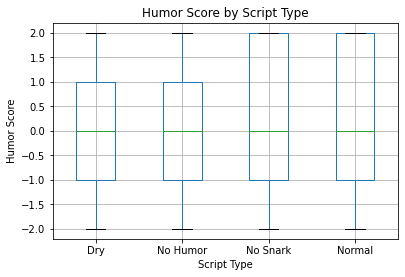

In [ ]:
all_grades.boxplot(column='humor_score', by='script_type', showfliers=False)
plt.suptitle('')
plt.title('Humor Score by Script Type')
plt.xlabel('Script Type')
plt.ylabel('Humor Score')

In [ ]:
%%R
humor = lm(humor_score ~ script_type, data = factors)
summary(humor)


Call:
lm(formula = humor_score ~ script_type, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2243 -1.1335 -0.1335  1.7757  1.9383 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.20313    0.03434   5.915 3.48e-09 ***
script_typeNo Snark  0.02121    0.04816   0.440  0.65969    
script_typeNo Humor -0.06961    0.04842  -1.438  0.15054    
script_typeDry      -0.14147    0.04764  -2.970  0.00299 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.426 on 7112 degrees of freedom
Multiple R-squared:  0.002045,	Adjusted R-squared:  0.001624 
F-statistic: 4.857 on 3 and 7112 DF,  p-value: 0.002236



In [ ]:
%%R
likability = lm(likability_score ~ script_type, data = factors)
summary(likability)


Call:
lm(formula = likability_score ~ script_type, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3024 -0.9095  0.6976  0.7100  1.0905 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.915844   0.026854  34.104   <2e-16 ***
script_typeNo Snark  0.374116   0.037657   9.935   <2e-16 ***
script_typeNo Humor -0.006389   0.037858  -0.169    0.866    
script_typeDry       0.386568   0.037248  10.378   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.115 on 7112 degrees of freedom
Multiple R-squared:  0.02879,	Adjusted R-squared:  0.02838 
F-statistic: 70.26 on 3 and 7112 DF,  p-value: < 2.2e-16



In [ ]:
"""
Call:
lm(formula = humor_score ~ script_type, data = factors)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.04413 -0.92463 -0.03504  0.96496  2.08264 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)          0.03504    0.03806   0.921   0.3572  
script_typeNo Snark  0.00909    0.05319   0.171   0.8643  
script_typeNo Humor -0.11041    0.05326  -2.073   0.0382 *
script_typeDry      -0.11768    0.05286  -2.226   0.0260 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.27 on 4635 degrees of freedom
Multiple R-squared:  0.002194,	Adjusted R-squared:  0.001548 
F-statistic: 3.397 on 3 and 4635 DF,  p-value: 0.01708
"""

'\nCall:\nlm(formula = humor_score ~ script_type, data = factors)\n\nResiduals:\n     Min       1Q   Median       3Q      Max \n-2.04413 -0.92463 -0.03504  0.96496  2.08264 \n\nCoefficients:\n                    Estimate Std. Error t value Pr(>|t|)  \n(Intercept)          0.03504    0.03806   0.921   0.3572  \nscript_typeNo Snark  0.00909    0.05319   0.171   0.8643  \nscript_typeNo Humor -0.11041    0.05326  -2.073   0.0382 *\nscript_typeDry      -0.11768    0.05286  -2.226   0.0260 *\n---\nSignif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1\n\nResidual standard error: 1.27 on 4635 degrees of freedom\nMultiple R-squared:  0.002194,\tAdjusted R-squared:  0.001548 \nF-statistic: 3.397 on 3 and 4635 DF,  p-value: 0.01708\n'

In [ ]:
%%R
# Linear regression on enjoyment score
enjoyment = lm(enjoyment_score ~ script_type + grade_level + reading_level + history_score + likability_score + humor_score, data = factors)
summary(enjoyment)


Call:
lm(formula = enjoyment_score ~ script_type + grade_level + reading_level + 
    history_score + likability_score + humor_score, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1042 -0.4264  0.2318  0.6044  2.4336 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.749660   0.038846  19.298  < 2e-16 ***
script_typeNo Snark        -0.086212   0.034142  -2.525 0.011590 *  
script_typeNo Humor         0.012983   0.034077   0.381 0.703220    
script_typeDry             -0.121016   0.033826  -3.578 0.000349 ***
grade_level4th              0.099054   0.036418   2.720 0.006546 ** 
grade_level5th              0.108685   0.036508   2.977 0.002921 ** 
grade_level6th              0.018572   0.038239   0.486 0.627220    
grade_levelOther            0.028781   0.036633   0.786 0.432105    
reading_levelBelow Average -0.138619   0.046972  -2.951 0.003178 ** 
reading_levelAbove Average  0.274420   0.027028  1

In [ ]:
"""
Call:
lm(formula = enjoyment_score ~ script_type + grade_level + reading_level + 
    history_score + likability_score + humor_score, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8422 -0.4989  0.1584  0.5544  2.9312 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.50129    0.04273  11.731  < 2e-16 ***
script_typeNo Snark        -0.04470    0.03564  -1.254   0.2098    
script_typeNo Humor         0.05925    0.03557   1.666   0.0958 .  
script_typeDry             -0.04638    0.03544  -1.309   0.1907    
grade_level4th              0.02567    0.03724   0.689   0.4907    
grade_level5th              0.11743    0.03851   3.050   0.0023 ** 
grade_level6th              0.01661    0.04109   0.404   0.6860    
grade_levelOther           -0.04946    0.03866  -1.280   0.2008    
reading_levelBelow Average -0.12140    0.05245  -2.315   0.0207 *  
reading_levelAbove Average  0.14468    0.02902   4.985 6.42e-07 ***
history_score               0.11361    0.01065  10.668  < 2e-16 ***
likability_score            0.37569    0.01359  27.636  < 2e-16 ***
humor_score                 0.11918    0.01069  11.153  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8269 on 4430 degrees of freedom
  (196 observations deleted due to missingness)
Multiple R-squared:  0.2824,	Adjusted R-squared:  0.2804 
F-statistic: 145.3 on 12 and 4430 DF,  p-value: < 2.2e-16
"""

'\nCall:\nlm(formula = enjoyment_score ~ script_type + grade_level + reading_level + \n    history_score + likability_score + humor_score, data = factors)\n\nResiduals:\n    Min      1Q  Median      3Q     Max \n-3.8422 -0.4989  0.1584  0.5544  2.9312 \n\nCoefficients:\n                           Estimate Std. Error t value Pr(>|t|)    \n(Intercept)                 0.50129    0.04273  11.731  < 2e-16 ***\nscript_typeNo Snark        -0.04470    0.03564  -1.254   0.2098    \nscript_typeNo Humor         0.05925    0.03557   1.666   0.0958 .  \nscript_typeDry             -0.04638    0.03544  -1.309   0.1907    \ngrade_level4th              0.02567    0.03724   0.689   0.4907    \ngrade_level5th              0.11743    0.03851   3.050   0.0023 ** \ngrade_level6th              0.01661    0.04109   0.404   0.6860    \ngrade_levelOther           -0.04946    0.03866  -1.280   0.2008    \nreading_levelBelow Average -0.12140    0.05245  -2.315   0.0207 *  \nreading_levelAbove Average  0.14468    

In [ ]:
%%R
enjoyment2 = lm(enjoyment_score ~ script_type + grade_level * reading_level + history_score + likability_score + humor_score, data = factors)
summary(enjoyment2)


Call:
lm(formula = enjoyment_score ~ script_type + grade_level * reading_level + 
    history_score + likability_score + humor_score, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0598 -0.4281  0.2308  0.6018  2.5329 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                  0.727018   0.049967  14.550
script_typeNo Snark                         -0.084026   0.034152  -2.460
script_typeNo Humor                          0.011417   0.034078   0.335
script_typeDry                              -0.121338   0.033835  -3.586
grade_level4th                               0.093961   0.066585   1.411
grade_level5th                               0.239643   0.065577   3.654
grade_level6th                              -0.008863   0.071579  -0.124
grade_levelOther                             0.037845   0.068823   0.550
reading_levelBelow Average                  -0.220277   0.075834  -2.905
reading_le

In [ ]:
"""
Call:
lm(formula = enjoyment_score ~ script_type + grade_level * reading_level + 
    history_score + likability_score + humor_score, data = factors)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8529 -0.5005  0.1525  0.5532  2.8370 

Coefficients:
                                             Estimate Std. Error t value
(Intercept)                                  0.531358   0.055655   9.547
script_typeNo Snark                         -0.046689   0.035691  -1.308
script_typeNo Humor                          0.054889   0.035649   1.540
script_typeDry                              -0.045537   0.035501  -1.283
grade_level4th                              -0.009551   0.072690  -0.131
grade_level5th                               0.117037   0.072286   1.619
grade_level6th                              -0.119698   0.079472  -1.506
grade_levelOther                            -0.048011   0.074356  -0.646
reading_levelBelow Average                  -0.195080   0.081669  -2.389
reading_levelAbove Average                   0.116350   0.059456   1.957
history_score                                0.114168   0.010679  10.691
likability_score                             0.374596   0.013617  27.509
humor_score                                  0.119143   0.010700  11.135
grade_level4th:reading_levelBelow Average   -0.021984   0.164672  -0.133
grade_level5th:reading_levelBelow Average    0.147409   0.174135   0.847
grade_level6th:reading_levelBelow Average    0.232736   0.207845   1.120
grade_levelOther:reading_levelBelow Average  0.137202   0.137536   0.998
grade_level4th:reading_levelAbove Average    0.044467   0.086040   0.517
grade_level5th:reading_levelAbove Average   -0.015985   0.086658  -0.184
grade_level6th:reading_levelAbove Average    0.172239   0.093758   1.837
grade_levelOther:reading_levelAbove Average -0.025352   0.089146  -0.284
                                            Pr(>|t|)    
(Intercept)                                   <2e-16 ***
script_typeNo Snark                           0.1909    
script_typeNo Humor                           0.1237    
script_typeDry                                0.1997    
grade_level4th                                0.8955    
grade_level5th                                0.1055    
grade_level6th                                0.1321    
grade_levelOther                              0.5185    
reading_levelBelow Average                    0.0170 *  
reading_levelAbove Average                    0.0504 .  
history_score                                 <2e-16 ***
likability_score                              <2e-16 ***
humor_score                                   <2e-16 ***
grade_level4th:reading_levelBelow Average     0.8938    
grade_level5th:reading_levelBelow Average     0.3973    
grade_level6th:reading_levelBelow Average     0.2629    
grade_levelOther:reading_levelBelow Average   0.3185    
grade_level4th:reading_levelAbove Average     0.6053    
grade_level5th:reading_levelAbove Average     0.8537    
grade_level6th:reading_levelAbove Average     0.0663 .  
grade_levelOther:reading_levelAbove Average   0.7761    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8269 on 4422 degrees of freedom
"""

'\nCall:\nlm(formula = enjoyment_score ~ script_type + grade_level * reading_level + \n    history_score + likability_score + humor_score, data = factors)\n\nResiduals:\n    Min      1Q  Median      3Q     Max \n-3.8529 -0.5005  0.1525  0.5532  2.8370 \n\nCoefficients:\n                                             Estimate Std. Error t value\n(Intercept)                                  0.531358   0.055655   9.547\nscript_typeNo Snark                         -0.046689   0.035691  -1.308\nscript_typeNo Humor                          0.054889   0.035649   1.540\nscript_typeDry                              -0.045537   0.035501  -1.283\ngrade_level4th                              -0.009551   0.072690  -0.131\ngrade_level5th                               0.117037   0.072286   1.619\ngrade_level6th                              -0.119698   0.079472  -1.506\ngrade_levelOther                            -0.048011   0.074356  -0.646\nreading_levelBelow Average                  -0.195080   0.08166